# Class 21: Network Filtering, Thresholding, & Sparsification

Goal of today's class:
1. Introduce network reduction/filtering/thresholding
2. Introduce biases emerging in thresholding
3. Introduce weighted disparity filter

*Acknowledgement: Much of this lesson is based on material from Matteo Chinazzi and Qian Zhang.*
__________

1. Come in. Sit down. Open Teams.
2. Find your notebook in your /Class_21/ folder.
________

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('axes', axisbelow=True)
rc('axes', fc='w')
rc('figure', fc='w')
rc('savefig', fc='w')

## Network Filtering, Thresholding, & Sparsification

Real networks are often big, dense, noisy, and full of redundant connections. Airline networks, coauthorship graphs, correlation networks, and bipartite projections all generate graphs where a huge fraction of node pairs are linked by something. If we try to visualize or analyze these networks directly, we quickly run into both conceptual and computational limits: the hairball plots are unreadable, and algorithms that scale with $|E|$ or worse (all-pairs shortest paths, betweenness, some community detection methods, large-scale simulations) become expensive.

In this chapter we study **network sparsification**: the problem of replacing a given graph by a much sparser graph on the same set of nodes that still *behaves like* the original for certain tasks. The sparsified graph should be small enough to work with comfortably, but still preserve the structures or statistics we care about: shortest paths, centralities, communities, flows, diffusion processes, and so on.

Intuitively, sparsification is about extracting a **backbone** or **skeleton** of a network: a reduced set of edges that carries most of the structural signal and discards as much redundancy and noise as possible.

<!-- 
### Sparsification
- Thresholding (on vertex or edge properties)
- K-core Decomposition
- Minimum Spanning Tree
- Disparity Filtering (aka Backbone Extraction)

### Coarse-Graining
- Causal emergence
- Renormalization
- "Supernodes"
- ...community detection? -->

In [2]:
G = nx.karate_club_graph()
nodes = list(G.nodes())
G_edges = list(G.edges())
pos = nx.spring_layout(G)

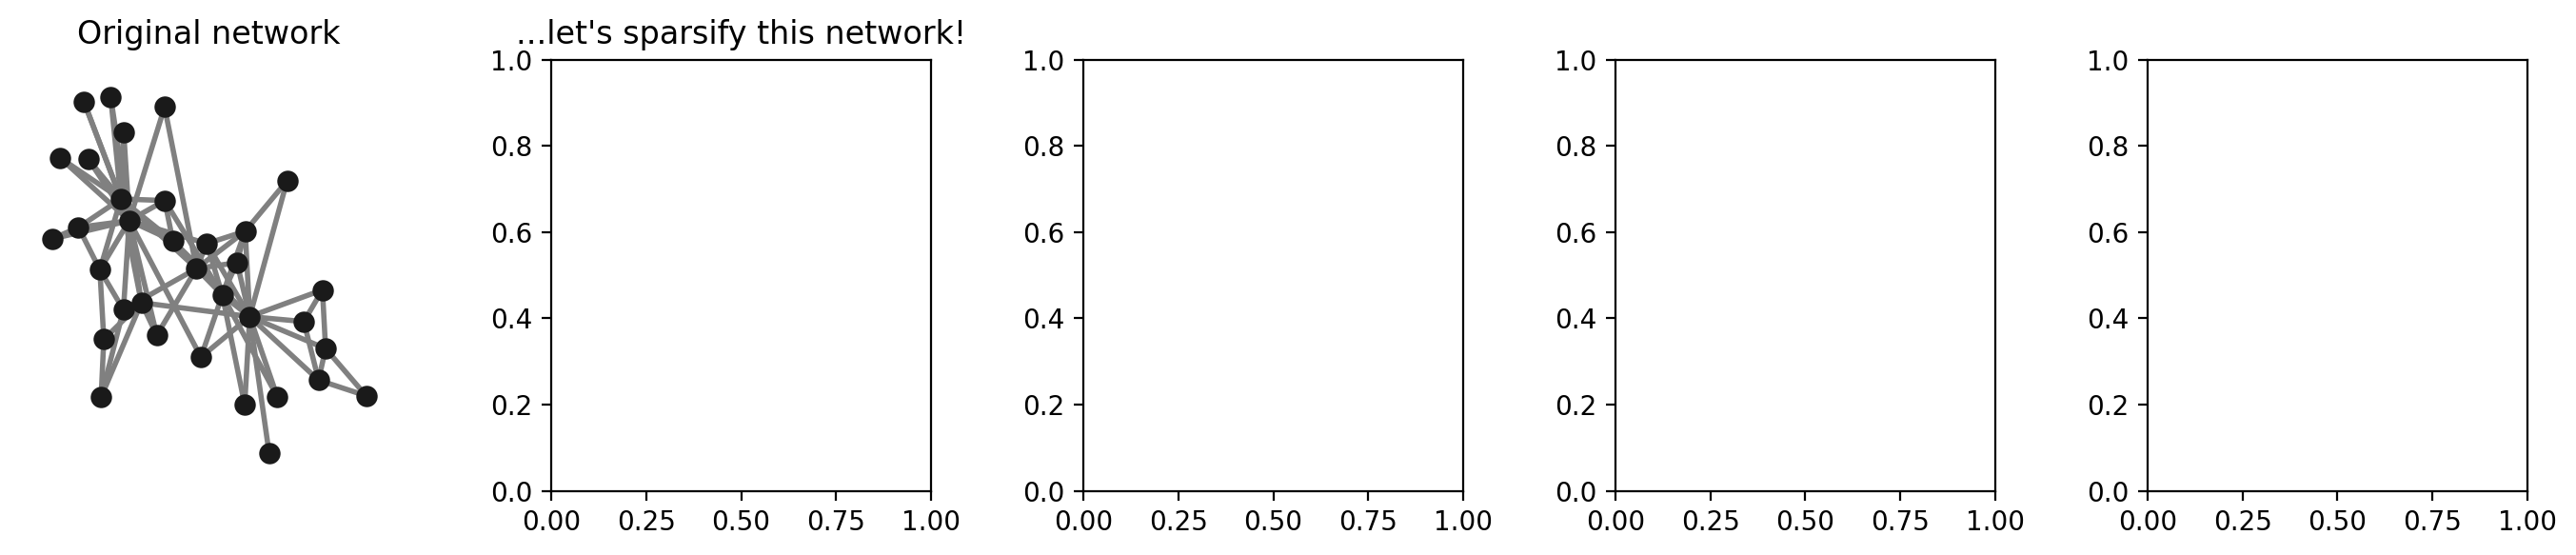

In [3]:
fig, ax = plt.subplots(1,5,figsize=(17,3),dpi=200)
plt.subplots_adjust(wspace=0.4)

nx.draw(G, pos, node_size=50, node_color='.1', edge_color='.5', width=2, ax=ax[0])
ax[0].set_title('Original network')

ax[1].set_title("...let's sparsify this network!")


plt.show()

...is sparsification as easy as just... removing edges?

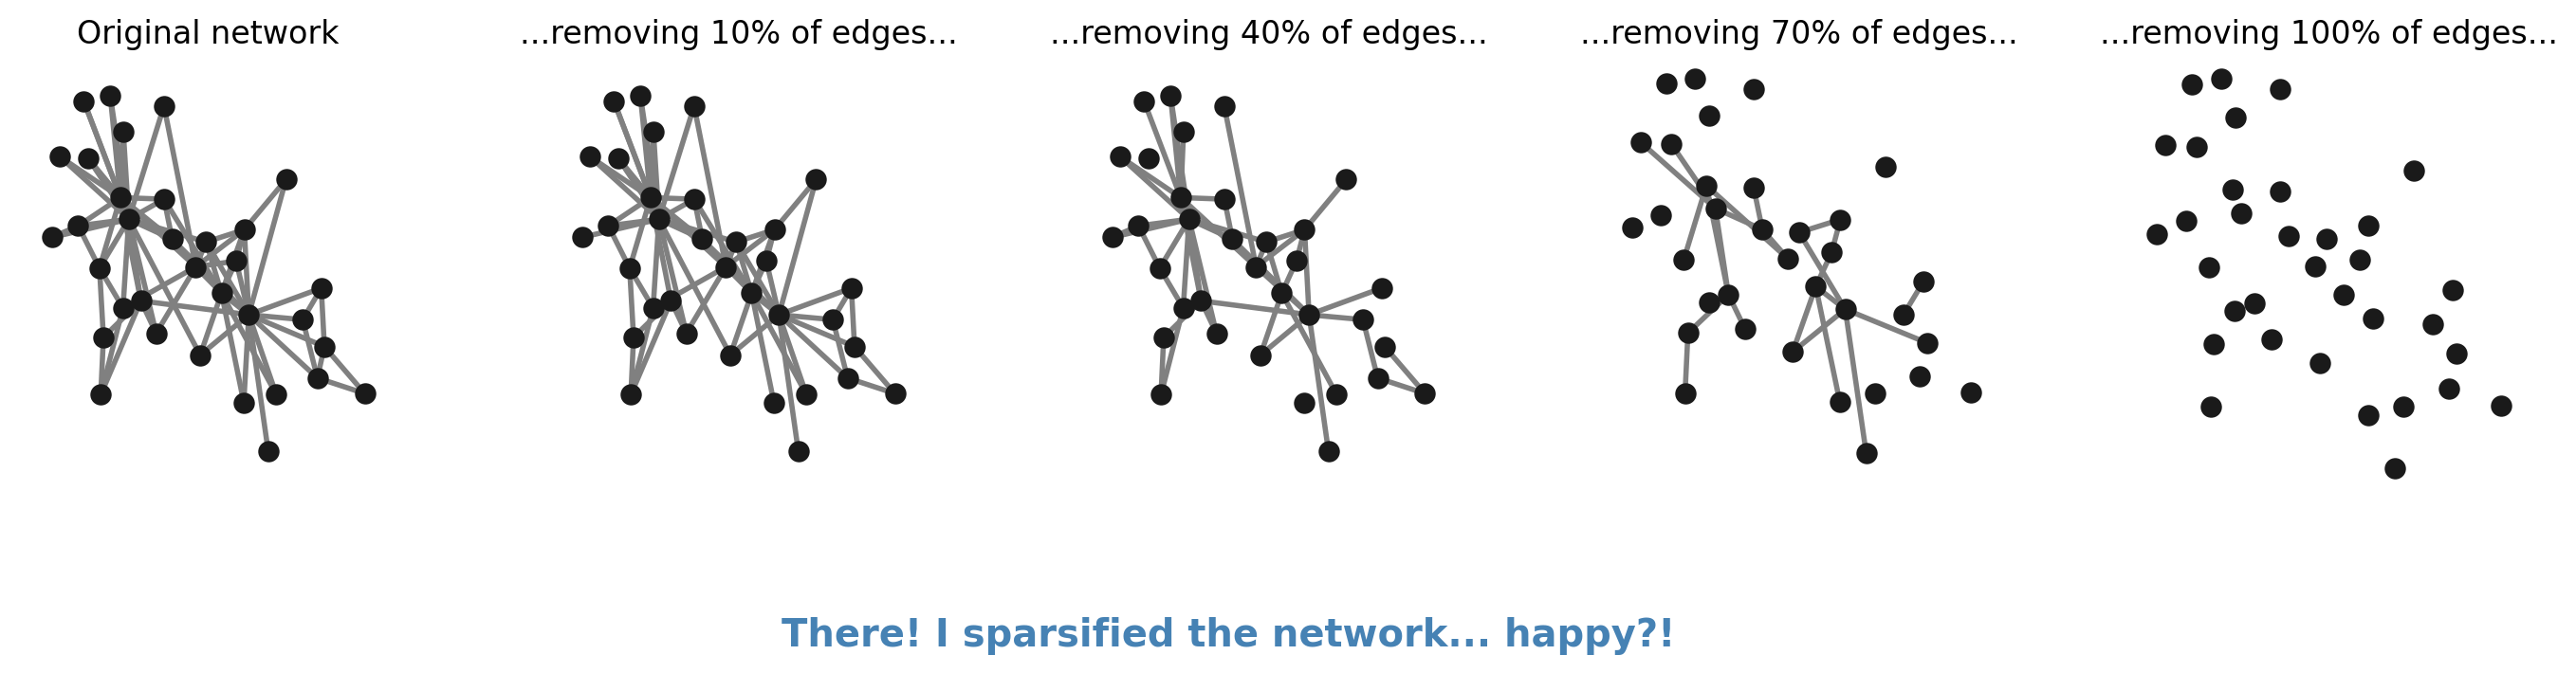

In [4]:
fig, ax = plt.subplots(1,5,figsize=(17,3),dpi=200)
plt.subplots_adjust(wspace=0.4)

nx.draw(G, pos, node_size=50, node_color='.1', edge_color='.5', width=2, ax=ax[0])
ax[0].set_title('Original network')


# remove 10% of edges
G2_edges = list(G.edges())
np.random.shuffle(G2_edges)
G2 = nx.Graph()
G2.add_nodes_from(nodes)
G2.add_edges_from(G2_edges[:int(0.9*len(G_edges))])
nx.draw(G2, pos, node_size=50, node_color='.1', edge_color='.5', width=2, ax=ax[1])
ax[1].set_title('...removing 10% of edges...')

# remove 40% of edges
G2_edges = list(G.edges())
np.random.shuffle(G2_edges)
G2 = nx.Graph()
G2.add_nodes_from(nodes)
G2.add_edges_from(G2_edges[:int(0.6*len(G_edges))])
nx.draw(G2, pos, node_size=50, node_color='.1', edge_color='.5', width=2, ax=ax[2])
ax[2].set_title('...removing 40% of edges...')

# remove 70% of edges
G2_edges = list(G.edges())
np.random.shuffle(G2_edges)
G2 = nx.Graph()
G2.add_nodes_from(nodes)
G2.add_edges_from(G2_edges[:int(0.3*len(G_edges))])
nx.draw(G2, pos, node_size=50, node_color='.1', edge_color='.5', width=2, ax=ax[3])
ax[3].set_title('...removing 70% of edges...')


# remove 100% of edges
G2_edges = list(G.edges())
np.random.shuffle(G2_edges)
G2 = nx.Graph()
G2.add_nodes_from(nodes)
G2.add_edges_from(G2_edges[:int(0.0*len(G_edges))])
nx.draw(G2, pos, node_size=50, node_color='.1', edge_color='.5', width=2, ax=ax[4])
ax[4].set_title('...removing 100% of edges...')


plt.suptitle('There! I sparsified the network... happy?!', color='steelblue', fontsize='x-large', y=-0.1, fontweight='bold')

plt.show()

_____________

### Sparsification, sampling, and filtering

It is useful to distinguish sparsification from a few closely related ideas that appear in other parts of the course.

**Sampling** asks how to select a subset of nodes or edges when we cannot or do not want to observe the full graph. The sampled graph is mainly a tool for *estimating* properties of an underlying, unobserved network.

**Filtering and thresholding** start from a weighted graph and ask which edges are statistically meaningful. Methods like disparity filters or likelihood-based backbones treat weights as noisy measurements, compare them to a null model, and keep only edges whose weights are unexpectedly large. The goal is to identify significant ties, not necessarily to approximate every structural aspect of the original network.

**Sparsification** assumes we already have the full graph and want to construct a smaller graph on the same nodes that approximates the original. Here we are not trying to estimate an unknown network; instead, we are constructing a surrogate graph that is cheaper to store, visualize, and analyze, while still supporting similar results for specific downstream tasks.

A convenient way to think about sparsification is as a two-step "score + filter" procedure:

1. Assign each edge $e \in E$ an importance score $s(e)$ based on some structural criterion (degree of its endpoints, neighborhood overlap, effective resistance, etc.).
2. Select a reduced edge set $E' \subset E$ using a global or local rule (for example, keep the top $q$ fraction of edges overall, or keep only the top $k$ edges incident to each node).


Most practical sparsification methods can be understood as choices of scoring function and filtering rule.

## What does it mean to *approximate* a graph?

A sparsifier of a graph $G = (V,E)$ is another graph $H = (V,E')$ on the same node set (usually) $|V(H)| = |V(G)|$ and a much smaller edge set $|E'| \ll |E|$ that approximates $G$ with respect to some property of interest. Different choices of property lead to different notions of sparsification:


- **Cut sparsifiers** approximate all $s$-$t$ cuts: for every subset $S \subseteq V$, the total weight of edges crossing the cut $\delta(S)$ in $H$ is within a factor $1 \pm \varepsilon$ of the cut weight in $G$. This guarantees that many flow and connectivity properties are preserved.


- **Spectral sparsifiers** approximate the graph Laplacian $L$. A graph $H$ is a spectral sparsifier of $G$ if for all vectors $x \in \mathbb{R}^n$,
  $$ (1 - \varepsilon)\, x^\top L x \;\le\; x^\top L_H x \;\le\; (1 + \varepsilon)\, x^\top L x. $$
  
  This single inequality implies that cuts, effective resistances, and many random-walk quantities in $H$ are close to those in $G$.


- **Distance sparsifiers and spanners** approximately preserve shortest-path distances. A subgraph $H$ is a $t$-spanner of $G$ if
  $$
  d_H(u,v) \;\le\; t \cdot d_G(u,v)
  $$
  for all node pairs $u,v$, where $d_G$ and $d_H$ denote shortest-path distances in $G$ and $H$, respectively.


These theoretical constructions show that, in principle, it is possible to compress a dense graph down to $O(n \log n)$ edges while still preserving strong global properties. In practice, however, such algorithms can be too heavy for everyday data analysis, and the property we care most about is usually much more specific than "all cuts" or "all quadratic forms". This motivates simpler, task-driven sparsifiers that are easier to implement and reason about.


In [5]:
edges = pd.read_csv('data/openflights_USairport_2010.txt', sep=' ', header=None,
                    names=['source','target','weight'])
nodes = pd.read_csv('data/openflights_airports.txt', sep=' ')


w_edge_dict = dict(zip(list(zip(edges['source'],edges['target'])), edges['weight']))

In [6]:
G = nx.Graph()
G.add_nodes_from(nodes['Airport ID'].values)
G.add_edges_from([(int(i),int(j),{'weight':k}) for i,j,k in list(edges.values)])

Gx = nx.subgraph(G, max(nx.connected_components(G), key=len))

In [7]:
N = G.number_of_nodes()
M = G.number_of_edges()
print("Number of Airports:", N)
print("Number of Connections:", M)

Number of Airports: 6675
Number of Connections: 17215


In [8]:
pos = dict(zip(nodes['Airport ID'].values, list(zip(nodes['Longitude'],nodes['Latitude']))))

In [9]:
for x in [i for i in G.nodes() if i not in pos.keys()]:
    try:
        pos[x] = pos[x+1]
    except:
        pos[x] = pos[x-1]

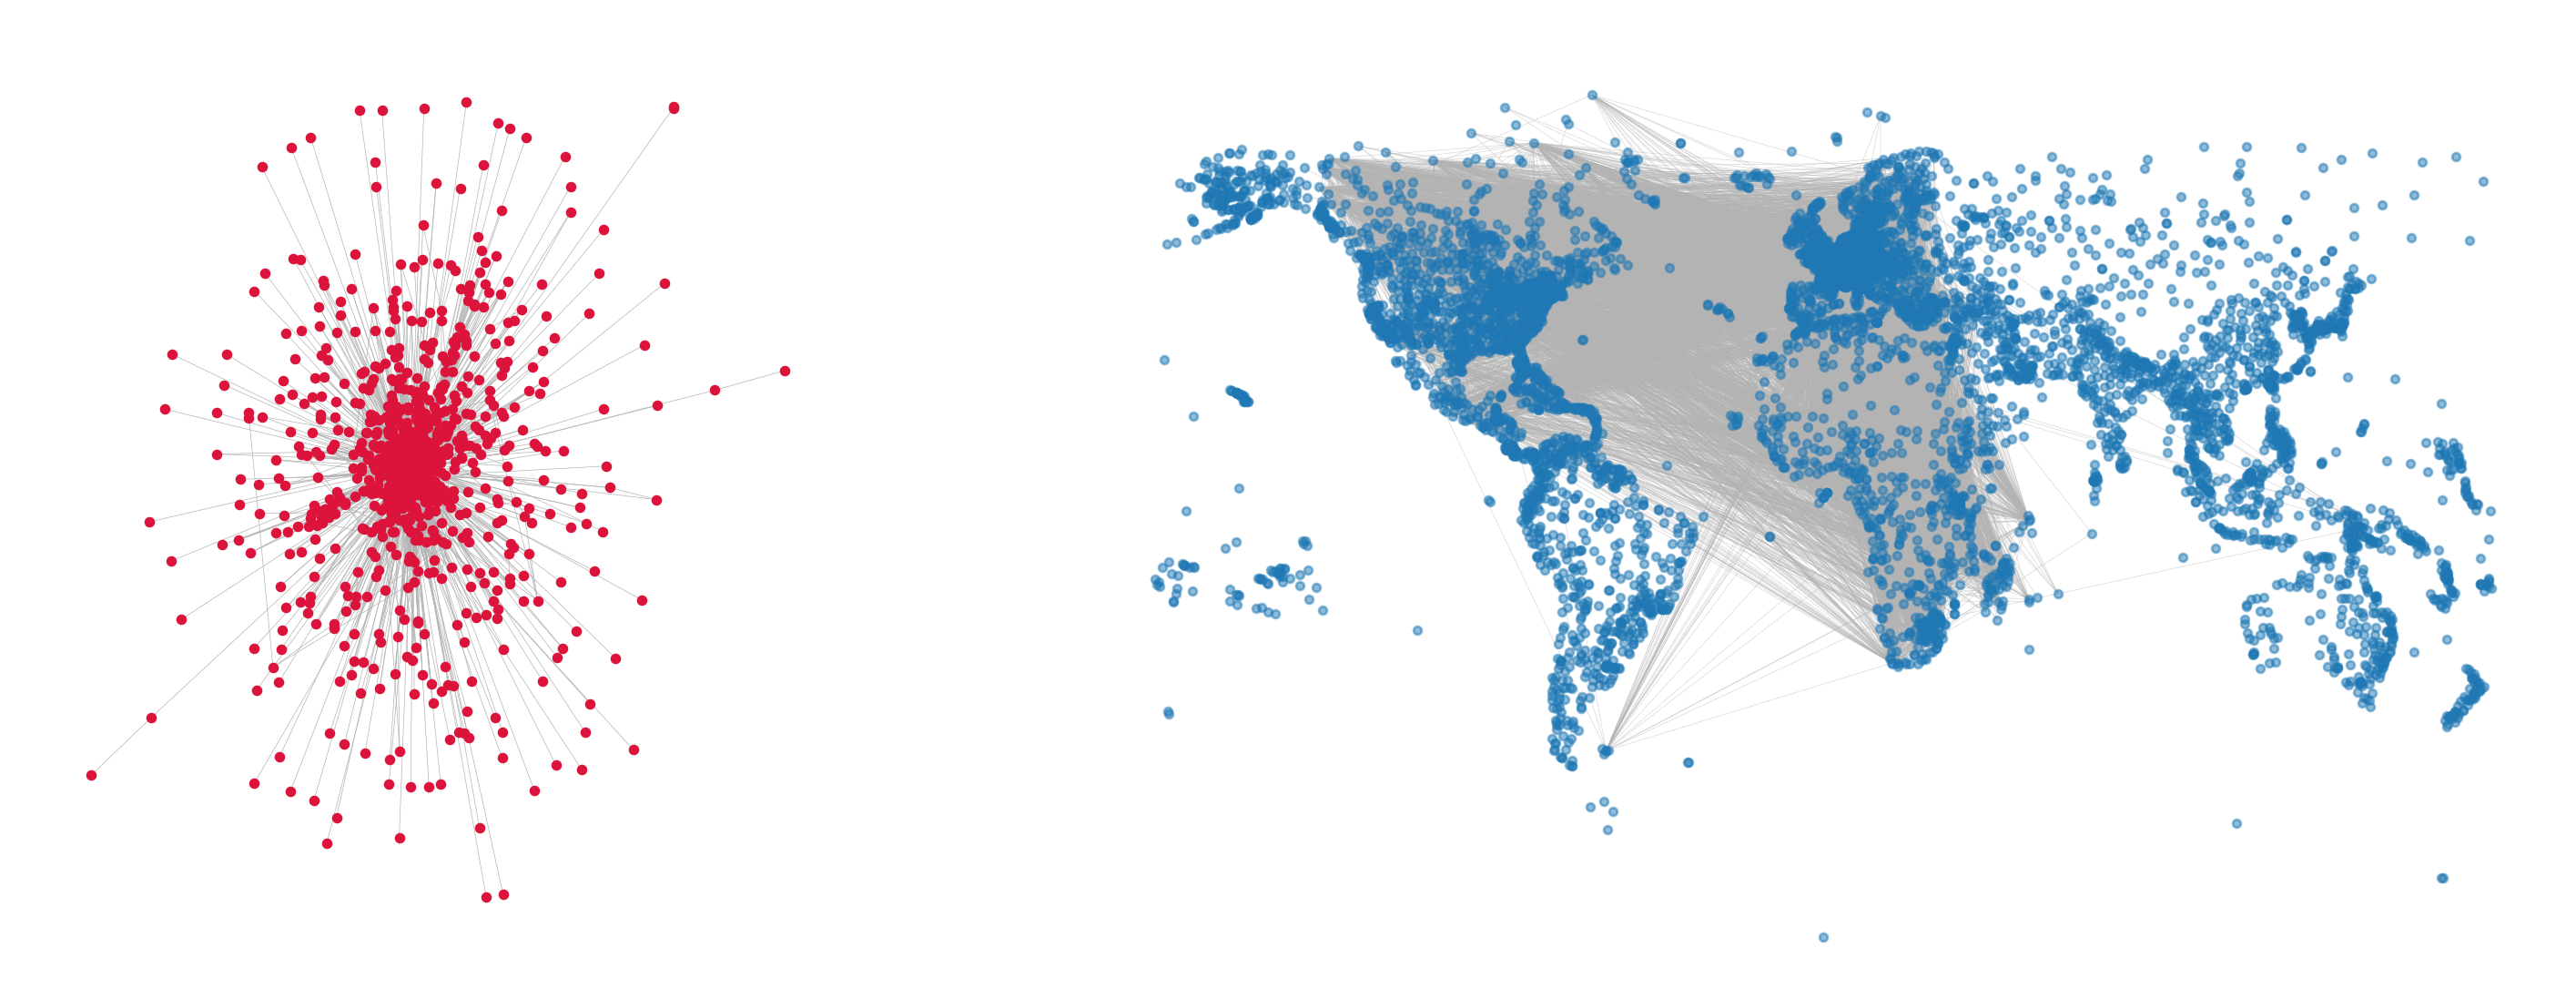

In [10]:
fig, ax = plt.subplots(1,2,figsize=(18,7),
                       gridspec_kw={'width_ratios':[2,3.5]},
                       dpi=200)

nx.draw(Gx, node_size=10, edge_color='.7', width=0.25, ax=ax[0], node_color='crimson')


nx.draw(G, pos={i:pos[i] for i in G.nodes()}, node_size=10,
        edge_color='.7', width=0.25, ax=ax[1], alpha=0.5)


plt.show()

In [11]:
def get_binning(data, num_bins=40, is_pmf=False, log_binning=False, threshold=0):
    """
    Bins the input data and calculates the probability mass function (PMF) or 
    probability density function (PDF) over the bins. Supports both linear and 
    logarithmic binning.

    Parameters
    ----------
    data : array-like
        The data to be binned, typically a list or numpy array of values.
    num_bins : int, optional
        The number of bins to use for binning the data (default is 15).
    is_pmf : bool, optional
        If True, computes the probability mass function (PMF) by normalizing 
        histogram counts to sum to 1. If False, computes the probability density 
        function (PDF) by normalizing the density of the bins (default is True).
    log_binning : bool, optional
        If True, uses logarithmic binning with log-spaced bins. If False, uses 
        linear binning (default is False).
    threshold : float, optional
        Only values greater than `threshold` will be included in the binning, 
        allowing for the removal of isolated nodes or outliers (default is 0).
    
    Returns
    -------
    x : numpy.ndarray
        The bin centers, adjusted to be the midpoint of each bin.
    p : numpy.ndarray
        The computed PMF or PDF values for each bin.
    
    Notes
    -----
    This function removes values below a specified threshold, then defines 
    bin edges based on the specified binning method (linear or logarithmic). 
    It calculates either the PMF or PDF based on `is_pmf`.
    """
    
    # Filter out isolated nodes or low values by removing data below threshold
    values = list(filter(lambda x: x > threshold, data))
    if len(values) != len(data):
        print("%s isolated nodes have been removed" % (len(data) - len(values)))

    # Define the range for binning (support of the distribution)
    lower_bound = min(values)
    upper_bound = max(values)

    # Define bin edges based on binning type (logarithmic or linear)
    if log_binning:
        # Use log-spaced bins by taking the log of the bounds
        lower_bound = np.log10(lower_bound)
        upper_bound = np.log10(upper_bound)
        bin_edges = np.logspace(lower_bound, upper_bound, num_bins + 1, base=10)
    else:
        # Use linearly spaced bins
        bin_edges = np.linspace(lower_bound, upper_bound, num_bins + 1)

    # Calculate histogram based on chosen binning method
    if is_pmf:
        # Calculate PMF: normalized counts of data in each bin
        y, _ = np.histogram(values, bins=bin_edges, density=False)
        p = y / y.sum()  # Normalize to get probabilities
    else:
        # Calculate PDF: normalized density of data in each bin
        p, _ = np.histogram(values, bins=bin_edges, density=True)

    # Compute bin centers (midpoints) to represent each bin
    x = bin_edges[1:] - np.diff(bin_edges) / 2  # Bin centers for plotting

    # Remove bins with zero probability to avoid plotting/display issues
    x = x[p > 0]
    p = p[p > 0]

    return x, p

5101 isolated nodes have been removed
5101 isolated nodes have been removed


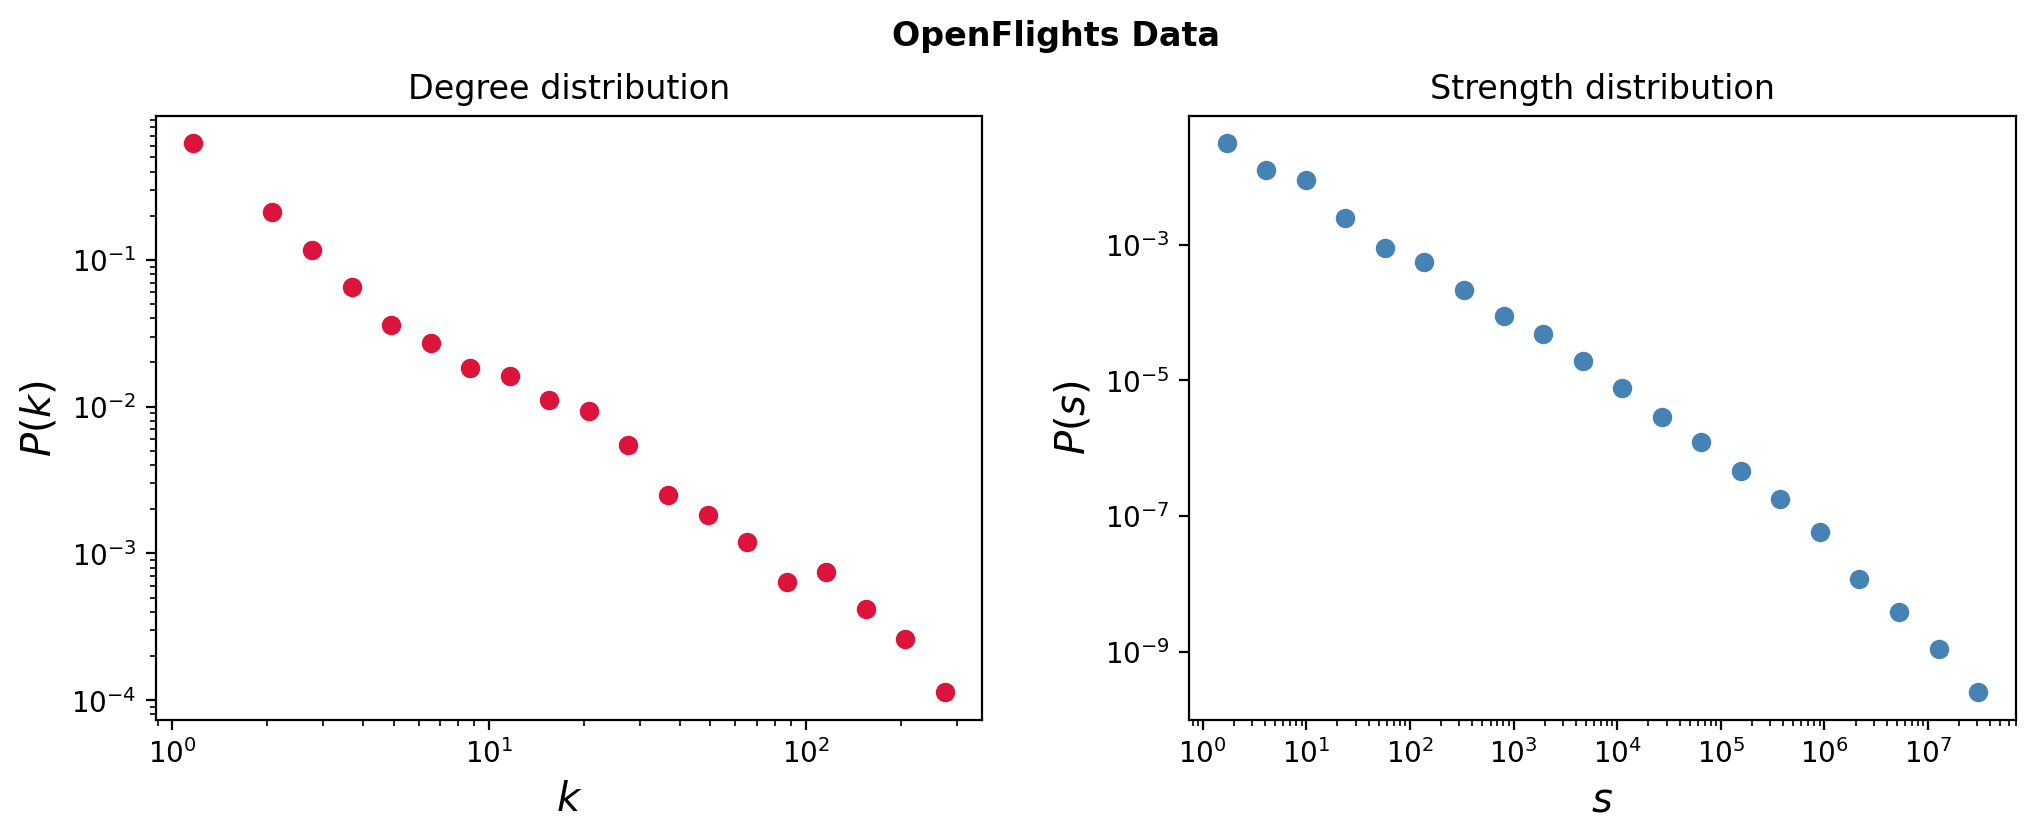

In [12]:
# Plot degree and strength distributions
fig, ax = plt.subplots(1,2,figsize=(12,4),dpi=200)
plt.subplots_adjust(wspace=0.25)

x, y = get_binning(list(dict(G.degree()).values()),
                   num_bins=20, log_binning=True)
ax[0].loglog(x,y,'o',color='crimson')
ax[0].set_ylabel(r'$P(k)$',fontsize='x-large')
ax[0].set_xlabel(r'$k$',fontsize='x-large')
ax[0].set_title('Degree distribution')

x, y = get_binning(list(dict(G.degree(weight='weight')).values()),
                   num_bins=20, log_binning=True)
ax[1].loglog(x,y,'o',color='steelblue')
ax[1].set_ylabel(r'$P(s)$',fontsize='x-large')
ax[1].set_xlabel(r'$s$',fontsize='x-large')
ax[1].set_title('Strength distribution')

plt.suptitle('OpenFlights Data',fontweight='bold',y=1.0)

plt.show()

___________
## Simple global thresholding

One of the most common ways to sparsify a **weighted** network is to apply a single global threshold on edge weights:

- keep edges with weight $w_{ij} > \tau$,
- drop edges with weight $w_{ij} \le \tau$.

This kind of **global thresholding** is easy to implement and often appears as a first preprocessing step for correlation networks, co-occurrence networks, or projected bipartite graphs.

However, it comes with serious drawbacks:

- It ignores/destroys heterogeneity in the network. Nodes with very small total strength (or low degrees) are disproportionately likely to lose all their edges when we apply a single global cutoff.
- It ignores local multi-scale structure. A single value of $\tau$ cannot preserve both strong ties between hubs and weaker—but locally important—ties between low-strength nodes.
- It tends to distort degree and strength distributions in ways that are hard to control, especially when edge weights span several orders of magnitude and lack a characteristic scale.

In the code below we implement a simple thresholding function and then explore how gradually increasing the weight threshold reshapes the degree and edge weight distributions of a weighted graph.


### Your turn!

In [13]:
def threshold_graph(G, threshold):
    """
    Return a globally thresholded version of a weighted graph.

    The function constructs a new graph H on (optionally) the same node set as G
    and keeps only those edges whose weight exceeds a global threshold.

    Parameters:
        G: A NetworkX graph with edge weights stored under `weight_key`.
        threshold: Global cutoff value. Only edges with weight > threshold
            are retained.

    Returns:
        G_thresh: A new NetworkX graph containing the thresholded edge set.
    """

    

    pass
    
#     return G_thresh

__________

In [14]:
def threshold_graph(G, threshold, weight_key="weight", copy_nodes=True):
    """
    Return a globally thresholded version of a weighted graph.

    The function constructs a new graph H on (optionally) the same node set as G
    and keeps only those edges whose weight exceeds a global threshold.

    Parameters:
        G: A NetworkX graph with edge weights stored under `weight_key`.
        threshold: Global cutoff value. Only edges with weight > threshold
            are retained.
        weight_key: Name of the edge attribute used as weight (default: "weight").
        copy_nodes: If True, copy all nodes (and their attributes) from G into H
            even if they become isolated. If False, only nodes incident to
            retained edges will appear in H.

    Returns:
        H: A new NetworkX graph containing the thresholded edge set.
    """
    H = G.__class__()  # preserve directed / undirected type

    if copy_nodes:
        H.add_nodes_from(G.nodes(data=True))

    for u, v, data in G.edges(data=True):
        w = data.get(weight_key)
        if w is None:
            continue
        if w > threshold:
            # keep all existing edge attributes
            H.add_edge(u, v, **data)

    return H

In [15]:
edges = pd.read_csv('data/openflights_USairport_2010.txt', sep=' ', header=None,
                    names=['source','target','weight'])
nodes = pd.read_csv('data/openflights_airports.txt', sep=' ')


w_edge_dict = dict(zip(list(zip(edges['source'],edges['target'])), edges['weight']))

G = nx.Graph()
G.add_nodes_from(nodes['Airport ID'].values)
G.add_edges_from([(int(i),int(j),{'weight':k}) for i,j,k in list(edges.values)])

Gx = nx.subgraph(G, max(nx.connected_components(G), key=len))

In [16]:
def get_binning(data, num_bins=50, is_pmf=False, log_binning=False, threshold=0):
    """
    Bins the input data and calculates the probability mass function (PMF) or 
    probability density function (PDF) over the bins. Supports both linear and 
    logarithmic binning.

    Parameters
    ----------
    data : array-like
        The data to be binned, typically a list or numpy array of values.
    num_bins : int, optional
        The number of bins to use for binning the data (default is 15).
    is_pmf : bool, optional
        If True, computes the probability mass function (PMF) by normalizing 
        histogram counts to sum to 1. If False, computes the probability density 
        function (PDF) by normalizing the density of the bins (default is True).
    log_binning : bool, optional
        If True, uses logarithmic binning with log-spaced bins. If False, uses 
        linear binning (default is False).
    threshold : float, optional
        Only values greater than `threshold` will be included in the binning, 
        allowing for the removal of isolated nodes or outliers (default is 0).
    
    Returns
    -------
    x : numpy.ndarray
        The bin centers, adjusted to be the midpoint of each bin.
    p : numpy.ndarray
        The computed PMF or PDF values for each bin.
    
    Notes
    -----
    This function removes values below a specified threshold, then defines 
    bin edges based on the specified binning method (linear or logarithmic). 
    It calculates either the PMF or PDF based on `is_pmf`.
    """
    
    # Filter out isolated nodes or low values by removing data below threshold
    values = list(filter(lambda x: x > threshold, data))
#     if len(values) != len(data):
#         print("%s isolated nodes have been removed" % (len(data) - len(values)))

    # Define the range for binning (support of the distribution)
    lower_bound = min(values)
    upper_bound = max(values)

    # Define bin edges based on binning type (logarithmic or linear)
    if log_binning:
        # Use log-spaced bins by taking the log of the bounds
        lower_bound = np.log10(lower_bound)
        upper_bound = np.log10(upper_bound)
        bin_edges = np.logspace(lower_bound, upper_bound, num_bins + 1, base=10)
    else:
        # Use linearly spaced bins
        bin_edges = np.linspace(lower_bound, upper_bound, num_bins + 1)

    # Calculate histogram based on chosen binning method
    if is_pmf:
        # Calculate PMF: normalized counts of data in each bin
        y, _ = np.histogram(values, bins=bin_edges, density=False)
        p = y / y.sum()  # Normalize to get probabilities
    else:
        # Calculate PDF: normalized density of data in each bin
        p, _ = np.histogram(values, bins=bin_edges, density=True)

    # Compute bin centers (midpoints) to represent each bin
    x = bin_edges[1:] - np.diff(bin_edges) / 2  # Bin centers for plotting

    # Remove bins with zero probability to avoid plotting/display issues
    x = x[p > 0]
    p = p[p > 0]

    return x, p

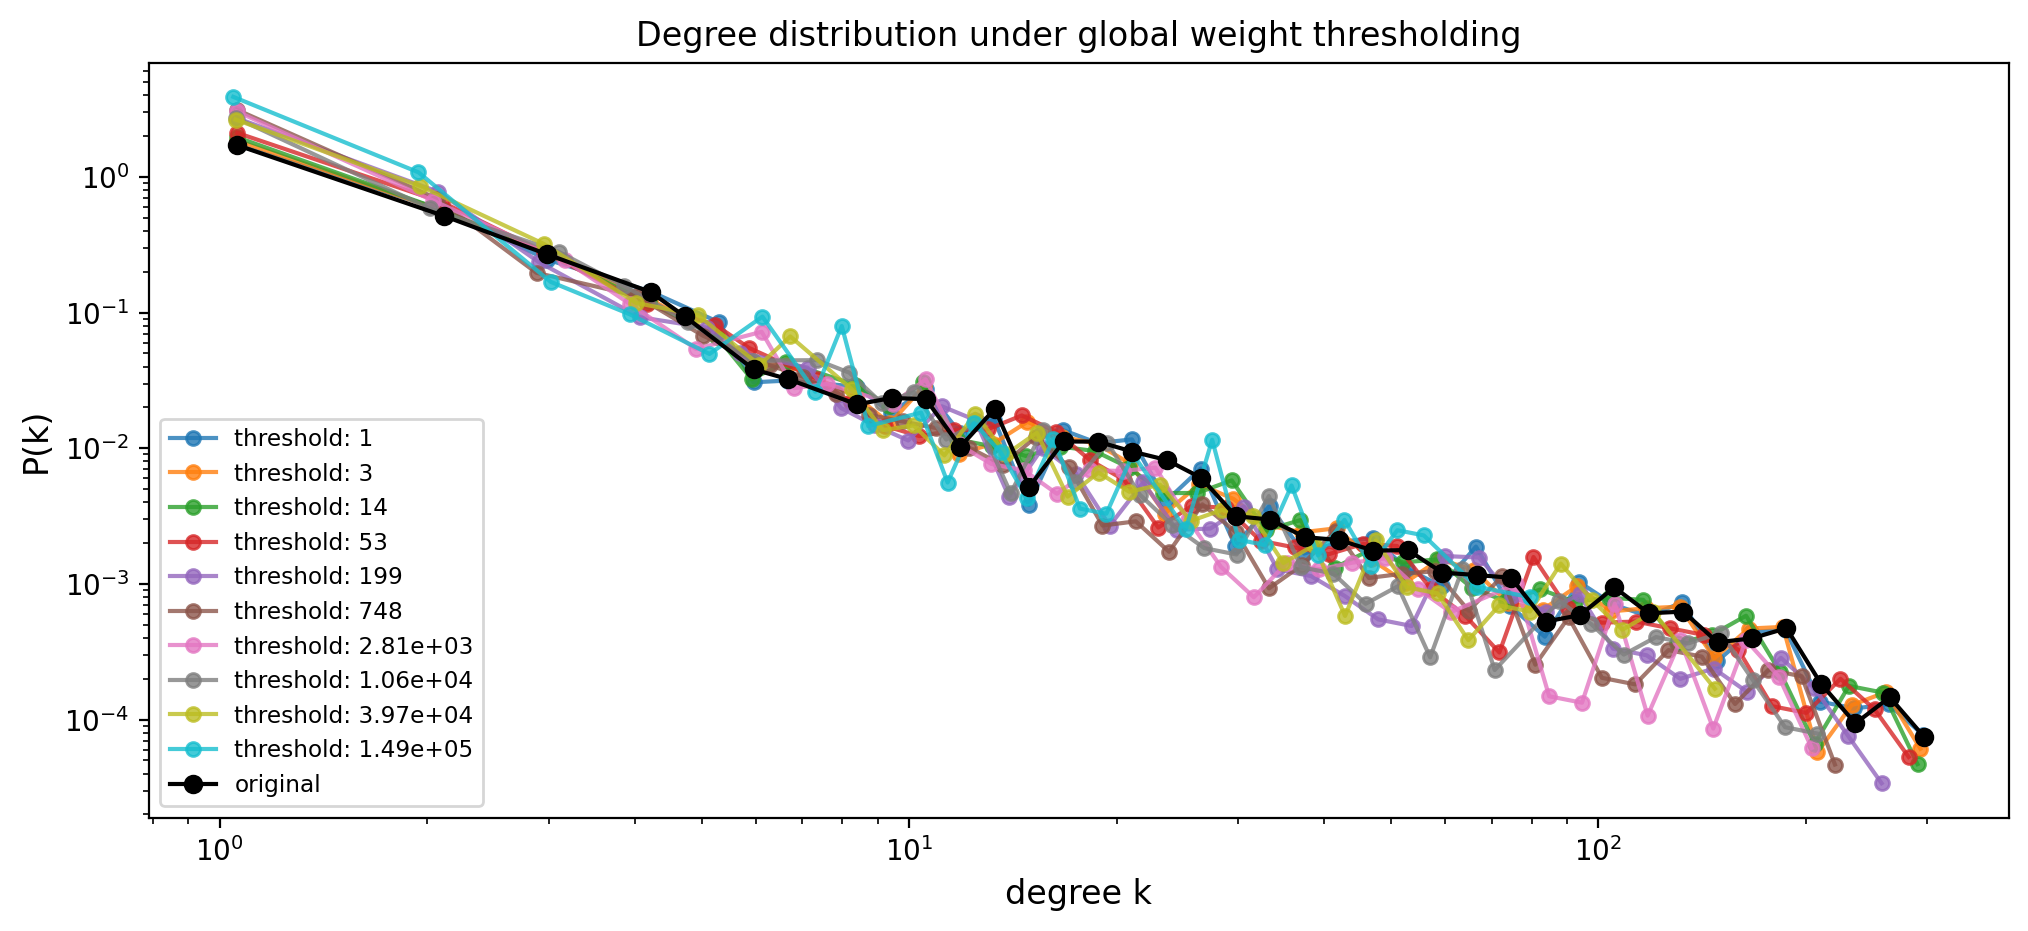

In [17]:
# Collect original edge weights
weights = list(nx.get_edge_attributes(G, "weight").values())
weights = np.array(weights)

min_w = weights.min()
max_w = weights.max()

# Use logarithmically spaced thresholds between min_w and max_w / 10
w_thresholds = np.logspace(np.log10(min_w),
                           np.log10(max_w) - 1,
                           10).astype(int)

fig, ax = plt.subplots(1,1,figsize=(12,5),dpi=200)

for w_threshold in w_thresholds:
    G_filtered = threshold_graph(Gx, w_threshold)
    frac_nodes = 100.0 * G_filtered.number_of_nodes() / float(N)

#     print(f"w_threshold: {w_threshold:.6g} ({frac_nodes:5.2f}% of nodes remain)")

    degrees_filtered = list(dict(G_filtered.degree()).values())
    x, y = get_binning(degrees_filtered, log_binning=True)
    ax.loglog(x, y, "o-", label=f"threshold: {w_threshold:.3g}", ms=5, alpha=0.8)

# Original degree distribution
x_true, y_true = get_binning(list(dict(G.degree()).values()), log_binning=True)
ax.loglog(x_true, y_true, "-o", label="original", color='k')

ax.set_xlabel("degree k", fontsize='large')
ax.set_ylabel("P(k)", fontsize='large')
ax.set_title("Degree distribution under global weight thresholding")
ax.legend(fontsize='small', loc=3)

plt.show()

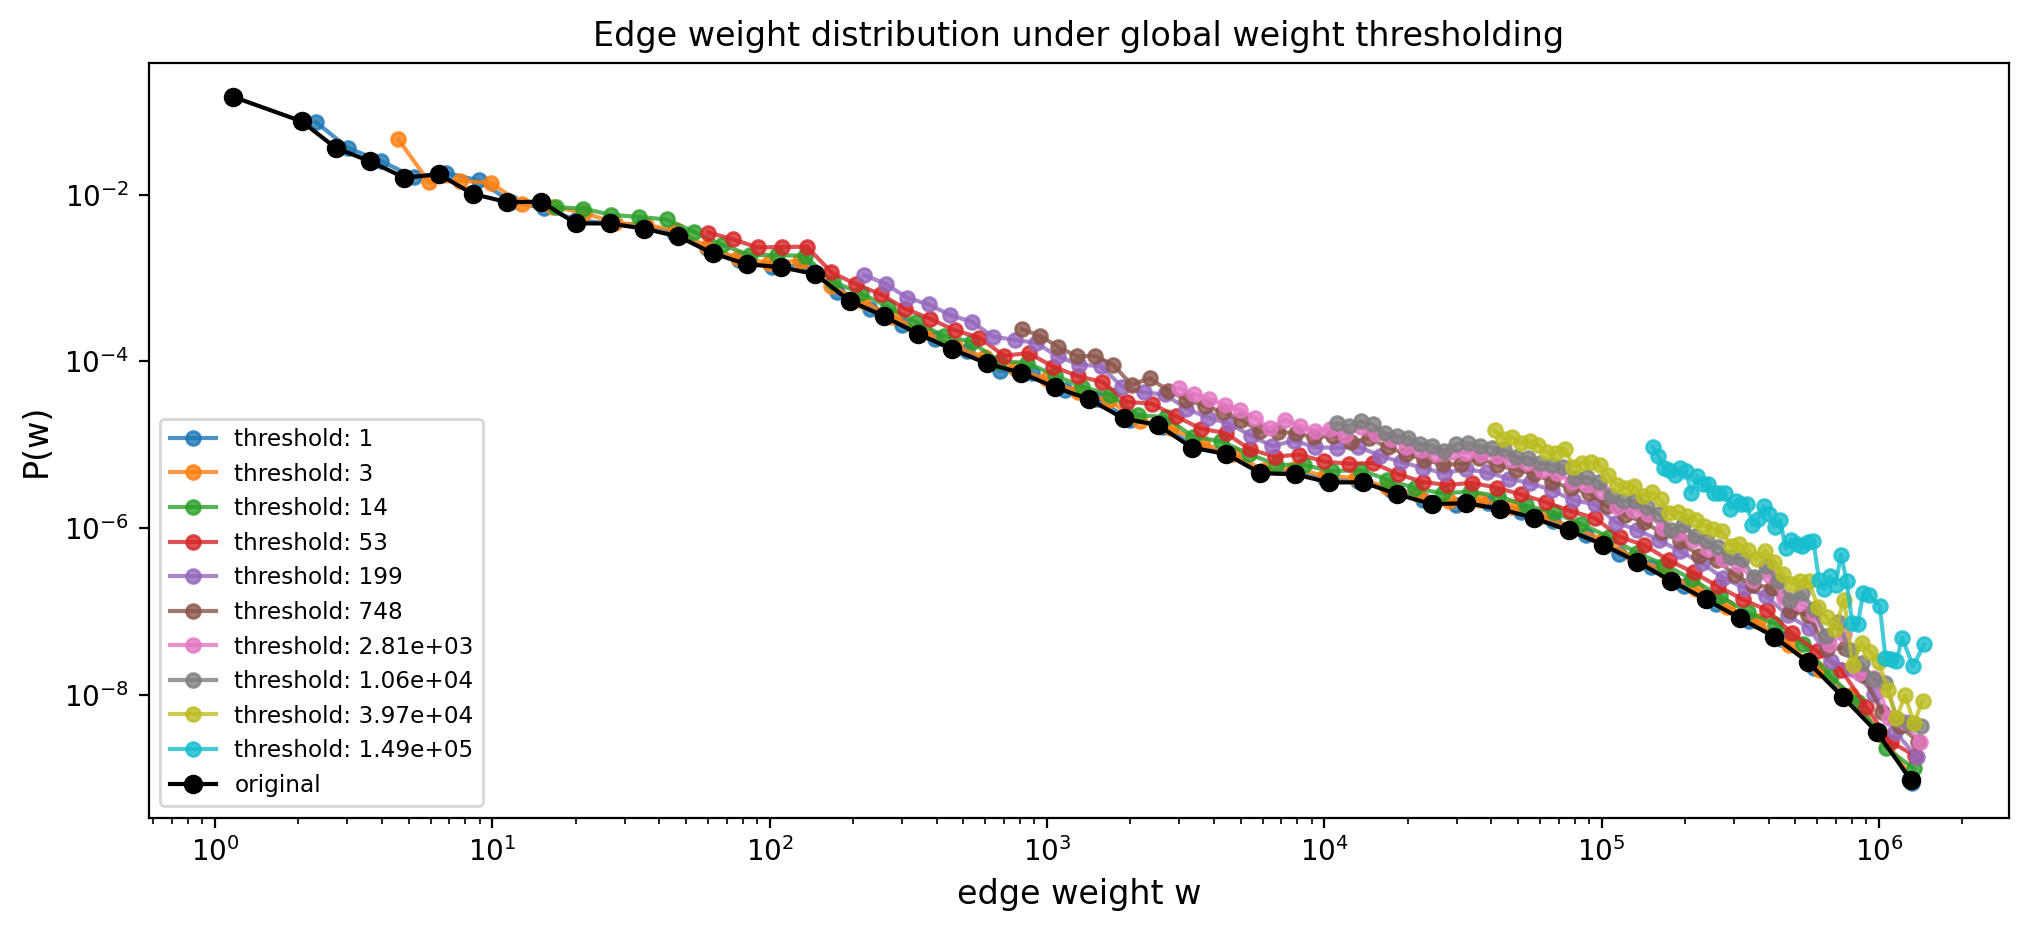

In [18]:
fig, ax = plt.subplots(1,1,figsize=(12,5),dpi=200)

for w_threshold in w_thresholds:
    G_filtered = threshold_graph(Gx, w_threshold)
    frac_nodes = 100.0 * G_filtered.number_of_nodes() / float(N)

#     print(f"w_threshold: {w_threshold:.6g} ({frac_nodes:5.2f}% of nodes remain)")

    weights_filtered = list(nx.get_edge_attributes(G_filtered, "weight").values())
    if len(weights_filtered) == 0:
        continue  # nothing left at this threshold

    x, y = get_binning(weights_filtered, log_binning=True)
    ax.loglog(x, y, "o-", label=f"threshold: {w_threshold:.3g}", ms=5, alpha=0.8)

# Original weight distribution
weights_original = list(nx.get_edge_attributes(G, "weight").values())
x_true, y_true = get_binning(weights_original, log_binning=True)
ax.loglog(x_true, y_true, "-o", label="original", color='k')

plt.xlabel("edge weight w", fontsize='large')
plt.ylabel("P(w)", fontsize='large')
plt.title("Edge weight distribution under global weight thresholding")
plt.legend(fontsize='small', loc=3)

plt.show()

### Maybe thresholding is too blunt...
Thresholding really chops off a lot of the network's information

## Spanning Trees

A **spanning tree** of a connected graph $G = (V, E)$ is a subgraph $T = (V, E_T)$ that:

1. contains all the nodes of $G$ (it “spans” $V$), and  
2. is a tree, i.e. it is connected and has no cycles.

Every spanning tree has exactly $|V| - 1$ edges. When the graph is weighted, we can look for spanning trees that are optimal with respect to the **sum of edge weights**. This leads to minimum and maximum spanning trees, which are often used as extremely sparse structural backbones.


### Minimum spanning trees

Given a connected weighted graph with edge weights $\{w_{ij}\}$, a **minimum spanning tree** (MinST) is a spanning tree $T$ that minimizes the total weight

$$ W(T) = \sum_{(i,j) \in E_T} w_{ij} $$

over all spanning trees of the graph. If all edge weights are distinct, the minimum spanning tree is unique.

Minimum spanning trees are natural when the edge weight represents a **cost** or **distance**:

- in transportation networks, $w_{ij}$ might be travel time or distance between locations;
- in infrastructure design, $w_{ij}$ can represent construction or maintenance cost.

In these settings, the MinST gives the cheapest way to connect all nodes without cycles. As a sparsification method, a minimum spanning tree is an **extreme** backbone (!!):

- it guarantees global connectivity using only $|V|-1$ edges;
- it typically preserves a rough sense of “short” routes between nodes;
- but it removes almost all redundancy and cycles, so clustering and community structure are nearly destroyed (global clustering coefficient becomes $0$ in a simple tree).

### Maximum spanning trees

When edge weights represent **similarities**, **flows**, or **capacities** (rather than costs), it is often more meaningful to look for a spanning tree that *maximizes* the total weight. A **maximum spanning tree** (sometimes also called a “maximum weight spanning tree”) is a spanning tree $T$ that maximizes

$$ W(T) = \sum_{(i,j) \in E_T} w_{ij}.$$ 

Here, large weights correspond to strong or important connections; the maximum spanning tree therefore selects a single, globally connected backbone built from the strongest available edges, subject to the constraint of having no cycles. As a structural backbone, this has similar pros and cons to the minimum spanning tree:

- the backbone is connected and uses only $|V|-1$ edges;
- it highlights the strongest ties in the network, often forming a “skeleton” that passes through hubs and major pathways;
- but it erases almost all clustering and community structure because trees have no cycles.

One standard way to compute a (minimum or maximum) spanning tree is **Kruskal's algorithm**:

1. Sort all edges by weight (ascending for a minimum spanning tree, descending for a maximum spanning tree).
2. Initialize an empty edge set $E_T$.
3. Consider edges in sorted order. For each edge, add it to $E_T$ **if and only if** it does not create a cycle with the edges already in $E_T$; otherwise discard it.
4. Stop when $|E_T| = |V| - 1$. The resulting subgraph is a spanning tree (minimum or maximum, depending on the sorting order).

We will not reimplement Kruskal’s algorithm here. Instead, we will use the built-in NetworkX routines to compute minimum and maximum spanning trees and then treat them as very sparse backbones for comparison with other sparsification methods.

#### Minimum vs. maximum spanning trees

Both minimum and maximum spanning trees are spanning trees: they use exactly $|V|-1$ edges, contain all nodes, and are cycle-free. The difference lies entirely in how they treat edge weights:

In a minimum spanning tree, edge weights are interpreted as *costs* or *distances*. The MinST chooses a set of edges that connects all nodes while minimizing the total cost $W_{\min}(T) = \sum_{(i,j)\in E_T} w_{ij}$. Shorter or cheaper edges are preferred, and long, expensive edges are used only when necessary to maintain connectivity.

In a maximum spanning tree, edge weights are interpreted as *strengths*, *similarities*, or *capacities*. The MaxST chooses a set of edges that connects all nodes while maximizing the total weight $ W_{\max}(T) = \sum_{(i,j)\in E_T} w_{ij}$. Strong or high-capacity edges are preferred; weak edges appear only when they are the only way to connect components.

Structurally, both MinST and MaxST are extremely sparse backbones that preserve global connectivity, eliminate almost all cycles and clustering, and differ mainly in which specific edges survive.

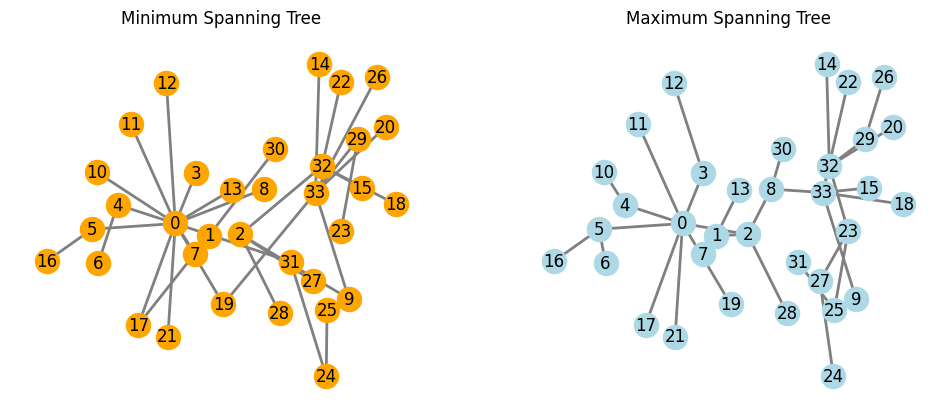

In [19]:
G = nx.karate_club_graph()
pos = nx.spring_layout(G)

fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

kc_min = nx.minimum_spanning_tree(G, algorithm="kruskal")
nx.draw(kc_min, pos, with_labels=True, node_color="orange", width=2, edge_color="gray", ax=ax[0])

kc_max = nx.maximum_spanning_tree(G, algorithm="kruskal")
nx.draw(kc_max, pos, with_labels=True, node_color="lightblue", width=2, edge_color="gray", ax=ax[1])

ax[0].set_title("Minimum Spanning Tree")
ax[1].set_title("Maximum Spanning Tree")

plt.show()

### Maybe spanning trees are too *fine*

Are there other techniques that allow for more preservation of **key** important structure?

A sort of Goldilocks sparsification technique...?


### Entering: The Sparsification Wars ;)

tl;dr, there are a ton of ways to do this task, and many of them are effective! We'll go over a few here and reference several others

_______

## The Disparity Filter: A local backbone for weighted networks

Global thresholding applies the same cutoff to all edges, regardless of how large or small a node’s total strength is. The **disparity filter** is a different approach: it uses a *local* null model at each node to identify edges whose weights are unexpectedly large compared to that node’s other connections.

The main idea is to preserve edges that carry a disproportionate fraction of a node's strength, while discarding edges whose weight is compatible with a "random" allocation of strength. In this way, the disparity filter extracts a multi-scale **backbone** of dominant connections that respects the heterogeneity of the network and preserves structural hierarchies even when edge weights span several orders of magnitude.

![](images/disparity_filter.png)

### Step 1: Normalizing edge weights

For a weighted, undirected graph, let $s_i$ denote the **strength** of node $i$ (the sum of weights of its incident edges), and let $w_{ij}$ be the weight of edge $(i,j)$. The first step is to normalize each edge weight by the total strength of its incident node.

For each node $i$ and neighbor $j$ we define the **normalized weight**

$$ p_{ij} = \frac{w_{ij}}{s_i}, $$

so that

$$ \sum_{j \in N(i)} p_{ij} = 1. $$

Intuitively, $p_{ij}$ is the fraction of $i$’s total strength that flows through edge $(i,j)$. Large values of $p_{ij}$ indicate edges that dominate $i$'s connections.


### Step 2: A local null model

Next we define a **null model** for how the normalized weights around a node might look *if there were no particular preference* for any neighbor.

For a node $i$ with degree $k_i$, the null model assumes that the unit interval $[0,1]$ is split into $k_i$ segments by placing $k_i-1$ cut points uniformly at random. The resulting segment lengths $ \{x_1, x_2, \dots, x_{k_i}\} $ represent the normalized weights $\{p_{ij}\}$ under a purely random allocation of strength.

Under this null model, the probability density of a single normalized weight $p$ is

$$ \rho(p) = (k_i - 1)(1 - p)^{k_i - 2}, \quad 0 \le p \le 1. $$

To assess whether an observed $p_{ij}$ is unusually large for node $i$, we compute the **one-sided $p$-value**: the probability that a random segment from this distribution is at least as large as $p_{ij}$,

$$ \alpha_{ij} = \Pr\big(X \ge p_{ij}\big)
               = 1 - (k_i - 1)\int_0^{p_{ij}} (1 - x)^{k_i - 2}\,dx
               = (1 - p_{ij})^{k_i - 1}.
$$

Small values of $\alpha_{ij}$ mean that it is very unlikely, under the null model, to see a normalized weight as large as $p_{ij}$ purely by chance.

### Step 3: Choosing a significance level and defining the backbone

We now select a **significance level** $\alpha$ (for example, $\alpha = 0.05$). For each edge $(i,j)$ we test the null model at each endpoint:

- compute $\alpha_{ij}$ using node $i$’s degree and strength,
- compute $\alpha_{ji}$ using node $j$’s degree and strength.

An edge is considered **statistically significant** for node $i$ if

$$ \alpha_{ij} < \alpha,$$

and similarly for node $j$. The edge $(i,j)$ is included in the backbone if it is significant for **at least one** of its endpoints.
_________

#### A few details:

- Nodes with degree $k_i = 1$ have no heterogeneity to test (there is only a single edge), so the null model is not very informative. In practice, the usual convention is:
  - if one endpoint has $k > 1$ and the other has $k = 1$, we only test significance using the endpoint with $k > 1$;
  - edges between two degree-1 nodes can be kept or discarded by convention, since they do not affect local heterogeneity.

By construction, the disparity filter uses *different* effective thresholds for different nodes, depending on their degree and strength. This allows it to preserve significant edges of low-strength nodes (which would be wiped out by a global threshold) and to retain only the most dominant edges of high-degree, high-strength hubs.


![](images/disparity_filter2.png)

In [20]:
def extract_backbone(G, alpha, weight_key="weight"):
    """
    Extract a disparity-filter backbone from a weighted, undirected graph.

    For each node n with degree k_n > 1, the function:
      1. Computes its strength
            s_n = sum_j w_{nj},
         where w_{nj} is the weight of edge (n, j).
      2. Computes normalized weights
            p_{nj} = w_{nj} / s_n.
      3. Evaluates the disparity-filter p-value
            alpha_{nj} = (1 - p_{nj})^(k_n - 1).
      4. If alpha_{nj} < alpha, the edge (n, j) is considered significant
         from n's perspective and is added to the backbone.

    Because we loop over all nodes, an undirected edge (i, j) can be added
    from either endpoint's perspective. In practice, this means edges that
    are significant for at least one endpoint are kept.

    Args:
        G: NetworkX graph. Assumed undirected, with positive edge weights.
        alpha: Significance level in (0, 1). Smaller alpha → sparser backbone.
        weight_key: Name of the edge attribute containing weights (default "weight").

    Returns:
        keep_graph: A new NetworkX Graph containing the backbone edges.
                    Node attributes and edge weights are not copied; only
                    the topology of the backbone is returned.
    """
    keep_graph = nx.Graph()

    # Loop over all nodes in the original graph
    for n in G.nodes():
        neighbors = list(G[n])
        k_n = len(neighbors)

        # Nodes with degree <= 1 do not contribute to the disparity test
        if k_n <= 1:
            continue

        # Total strength s_n of node n
        sum_w = 0.0
        for nj in neighbors:
            sum_w += G[n][nj][weight_key]

        if sum_w <= 0:
            # If total strength is non-positive, skip this node
            continue

        # Examine each neighbor and test significance of the normalized weight
        for nj in neighbors:
            w_nj = G[n][nj][weight_key]
            p_nj = w_nj / sum_w  # normalized weight p_{nj}

            # Disparity-filter p-value: alpha_{nj} = (1 - p_{nj})^(k_n - 1)
            p_value = (1.0 - p_nj) ** (k_n - 1)

            # If p-value is below the chosen significance level, keep the edge
            if p_value < alpha:
                keep_graph.add_edge(n, nj)

    return keep_graph


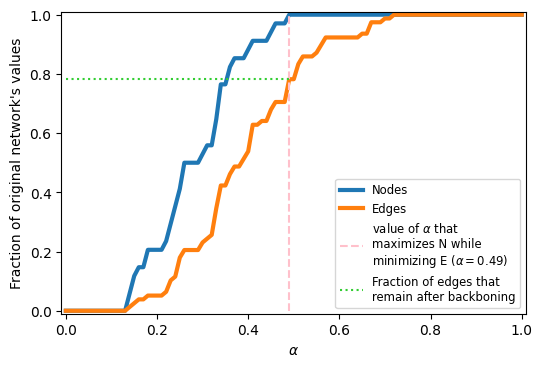

In [21]:
alphas = np.linspace(0,1,101)
G = nx.karate_club_graph()

N_vals = []
E_vals = []

for a in alphas:
    G_i = extract_backbone(G, a)
    N_vals.append(G_i.number_of_nodes()/\
                  G.number_of_nodes())
    E_vals.append(G_i.number_of_edges()/\
                  G.number_of_edges())
    

fig, ax = plt.subplots(1,1,figsize=(6,4),dpi=100)
ax.plot(alphas, N_vals, label='Nodes', lw=3)
ax.plot(alphas, E_vals, label='Edges', lw=3)

ideal_val_index = np.where(np.array(N_vals)==1.0)[0][0]
ax.vlines(alphas[ideal_val_index],0,1,color='pink',ls='--',
          label=r'value of $\alpha$ that'+'\nmaximizes N while'+'\nminimizing E '+\
                r'($\alpha=%.2f$)'%alphas[ideal_val_index])

ax.hlines(E_vals[ideal_val_index], 0, alphas[ideal_val_index], color='limegreen',
          ls=':', label='Fraction of edges that\nremain after backboning')

ax.legend(fontsize='small')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel("Fraction of original network's values")
ax.set_ylim(-0.01,1.01)
ax.set_xlim(-0.01,1.01)

plt.show()

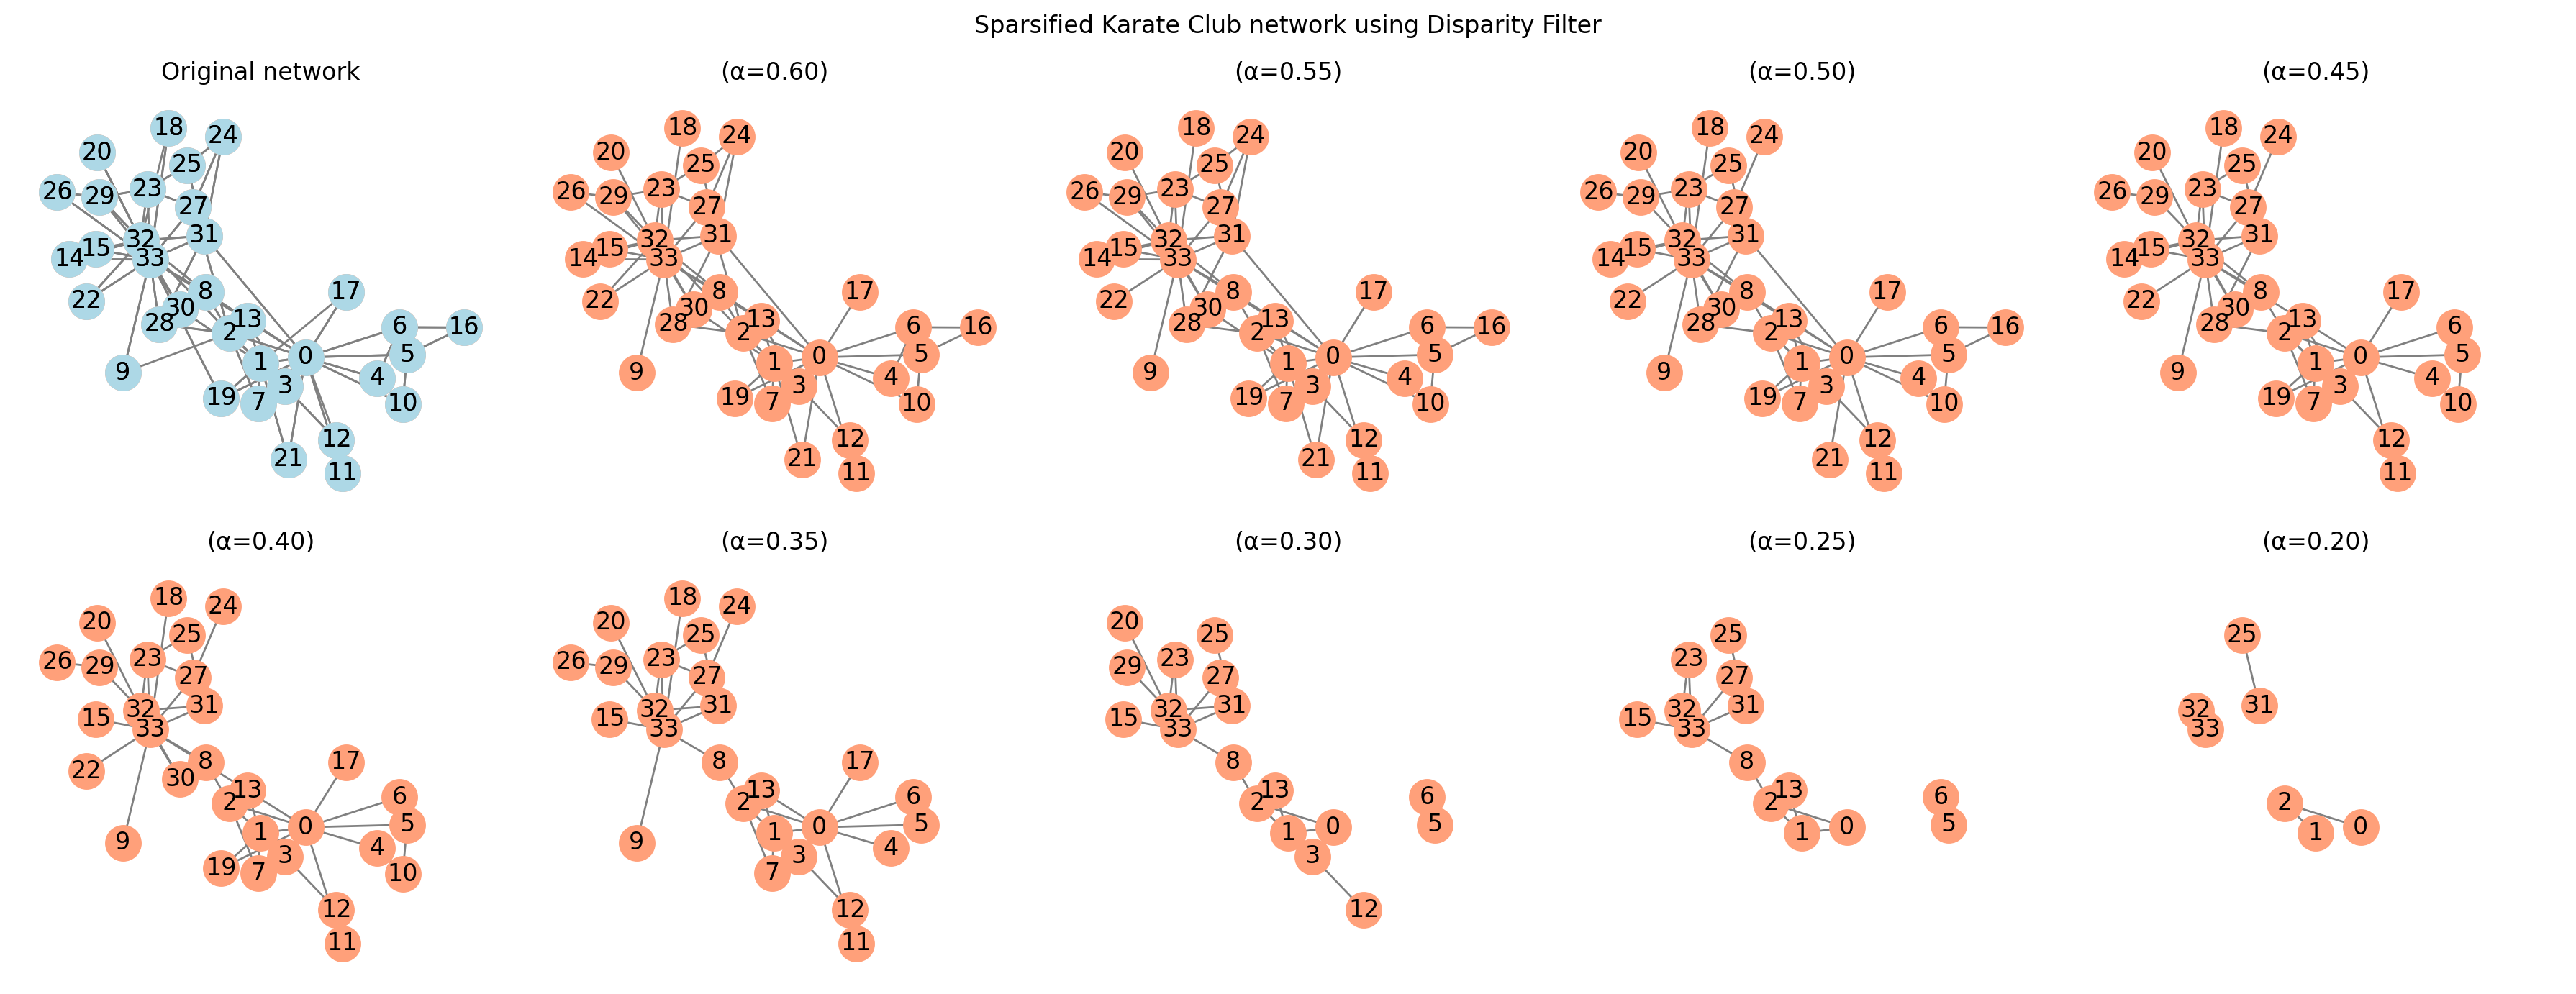

In [22]:
sparsified_graphs = {}
alphas = np.arange(0.2, 0.7, 0.05)

positions = nx.spring_layout(G, seed=3141592)

fig, axes = plt.subplots(2, 5, figsize=(18, 7), sharex=True, sharey=True, dpi=200) 

for i, alpha in enumerate(alphas):
    sparsified_graphs[alpha] = extract_backbone(G, alpha)
    
    nx.draw(
        sparsified_graphs[alpha], 
        pos=positions, 
        ax=axes.flat[-(i + 1)], 
        with_labels=True, 
        node_color="lightsalmon", 
        edge_color="gray"
    )
    axes.flat[-(i + 1)].set_title(f"(α={alpha:.2f})")

# Original network
nx.draw(
    G, 
    pos=positions, 
    ax=axes.flat[0], 
    with_labels=True, 
    node_color="lightblue", 
    edge_color="gray"
)
axes.flat[0].set_title("Original network")
plt.suptitle("Sparsified Karate Club network using Disparity Filter")
plt.tight_layout()

plt.show()

![](images/disparity_filter3.png)

_________

## Marginal Likelihood Filter

The Marginal Likelihood Filter (MLF), proposed by Dianati, is another statistical backbone extraction method for weighted networks. Whereas the disparity filter evaluates each edge from the *local* perspective of a single node, the MLF uses a global configuration-model-style null that depends on the strengths of *both* endpoints. This makes it more sensitive to edges that are unexpectedly strong given the strengths of the two nodes they connect.


### Mathematical framework for the MLF

Assume we have an undirected weighted graph where edge weights $w_{ij}$ are **non-negative integers** counting discrete events (flights between airports, co-occurrences of words, etc.). Let $ s_i = \sum_j w_{ij} $  be the (integer) strength of node $i$, and let $ T = \sum_{i<j} w_{ij} $ be the total number of unit edge contributions in the network.

The MLF null model imagines that these $T$ unit contributions are assigned independently to unordered node pairs $(i,j)$, with probabilities proportional to the product of their strengths. Under this model, the probability that a single unit chooses the pair $(i,j)$ is

$$ p_{ij} = \frac{s_i s_j}{2 T^2},$$

so the total weight $\sigma_{ij}$ realized on edge $(i,j)$ follows a binomial distribution

$$ \Pr\big[\sigma_{ij} = m \,\big|\, s_i, s_j, T\big] = \binom{T}{m} p_{ij}^{\,m}\, (1-p_{ij})^{T-m}, \qquad m = 0,1,\dots,T. $$

Given an observed edge weight $w_{ij}$, the **$p$–value** under the null model is the probability of observing a value at least this large by chance: 

$$ P(\sigma_{ij} \ge w_{ij}) = \sum_{m = w_{ij}}^{T} \binom{T}{m} p_{ij}^{\,m}\, (1-p_{ij})^{T-m} = 1 - \sum_{m = 0}^{w_{ij}-1} \binom{T}{m} p_{ij}^{\,m}\, (1-p_{ij})^{T-m}.$$


As with the disparity filter, we fix a significance level $\alpha$ (for example, $\alpha = 0.01$) and retain edge $(i,j)$ in the backbone if  $P(\sigma_{ij} \ge w_{ij}) \le \alpha$.

Edges that pass this test are those whose observed weight is too large to be explained by the null model that redistributes $T$ unit events at random proportional to node strengths. Because $p_{ij}$ depends on both $s_i$ and $s_j$, the MLF can down-weight edges between very strong nodes (for which large weights are expected) and highlight unexpectedly strong ties involving weaker nodes.

In [23]:
from scipy.stats import binom

def marginal_likelihood_filter(G, alpha, weight_key="weight"):
    """
    Extract the backbone of a weighted, undirected network using the
    Marginal Likelihood Filter (MLF) of Dianati (2016).

    The method assumes integer edge weights w_ij representing counts of
    discrete events (e.g., flights, co-occurrences). Let

        s_i = sum_j w_ij          (strength of node i)
        T   = sum_{i<j} w_ij      (total number of unit edge contributions)

    Under the null model, each of the T unit contributions independently
    chooses an unordered pair (i, j) with probability

        p_ij = s_i * s_j / (2 * T^2),

    so the realized edge weight sigma_ij follows a Binomial(T, p_ij)
    distribution. For each observed edge (i, j) with weight w_ij, the
    p-value is

        p_value = P(sigma_ij >= w_ij)
                = 1 - BinomCDF(w_ij - 1; T, p_ij).

    The backbone keeps only those edges whose p-value is at most alpha.

    Parameters
    ----------
    G : networkx.Graph
        Undirected weighted graph. Edge weights should be non-negative
        integers stored under `weight_key`.
    alpha : float
        Significance level (0 < alpha < 1). Smaller values yield sparser
        backbones.
    weight_key : str, optional
        Name of the edge attribute containing integer weights
        (default: "weight").

    Returns
    -------
    backbone : networkx.Graph
        A graph containing only the edges that pass the Marginal Likelihood
        Filter at the given significance level. Node attributes are copied
        from G, and edge weights are preserved.
    """
    if G.is_directed():
        raise ValueError("marginal_likelihood_filter assumes an undirected graph.")

    # New graph for the backbone; preserve graph type and node attributes
    backbone = G.__class__()
    backbone.add_nodes_from(G.nodes(data=True))

    # Compute node strengths and total weight T = sum_{i<j} w_ij
    strengths = {node: 0.0 for node in G.nodes()}
    T = 0.0

    for u, v, data in G.edges(data=True):
        w_uv = data.get(weight_key, 0.0)
        if w_uv <= 0:
            continue
        strengths[u] += w_uv
        strengths[v] += w_uv
        T += w_uv

    if T <= 0:
        # No positive weights, nothing to do
        return backbone

    # For each edge, compute its binomial p-value under the null model
    for u, v, data in G.edges(data=True):
        w_uv = data.get(weight_key, 0.0)
        if w_uv <= 0:
            continue

        s_u = strengths[u]
        s_v = strengths[v]

        # Edge probability under the null:
        # p_ij = s_i * s_j / (2 * T^2)
        p_ij = (s_u * s_v) / (2.0 * T**2)

        # Numerical safety: clamp p_ij to [0, 1]
        p_ij = max(0.0, min(1.0, p_ij))

        # p-value: P(sigma_ij >= w_uv) = 1 - CDF(w_uv - 1)
        # Note: binom.cdf(k, n, p) = P(X <= k)
        p_value = 1.0 - binom.cdf(w_uv - 1, int(T), p_ij)

        if p_value <= alpha:
            backbone.add_edge(u, v, **data)

    return backbone

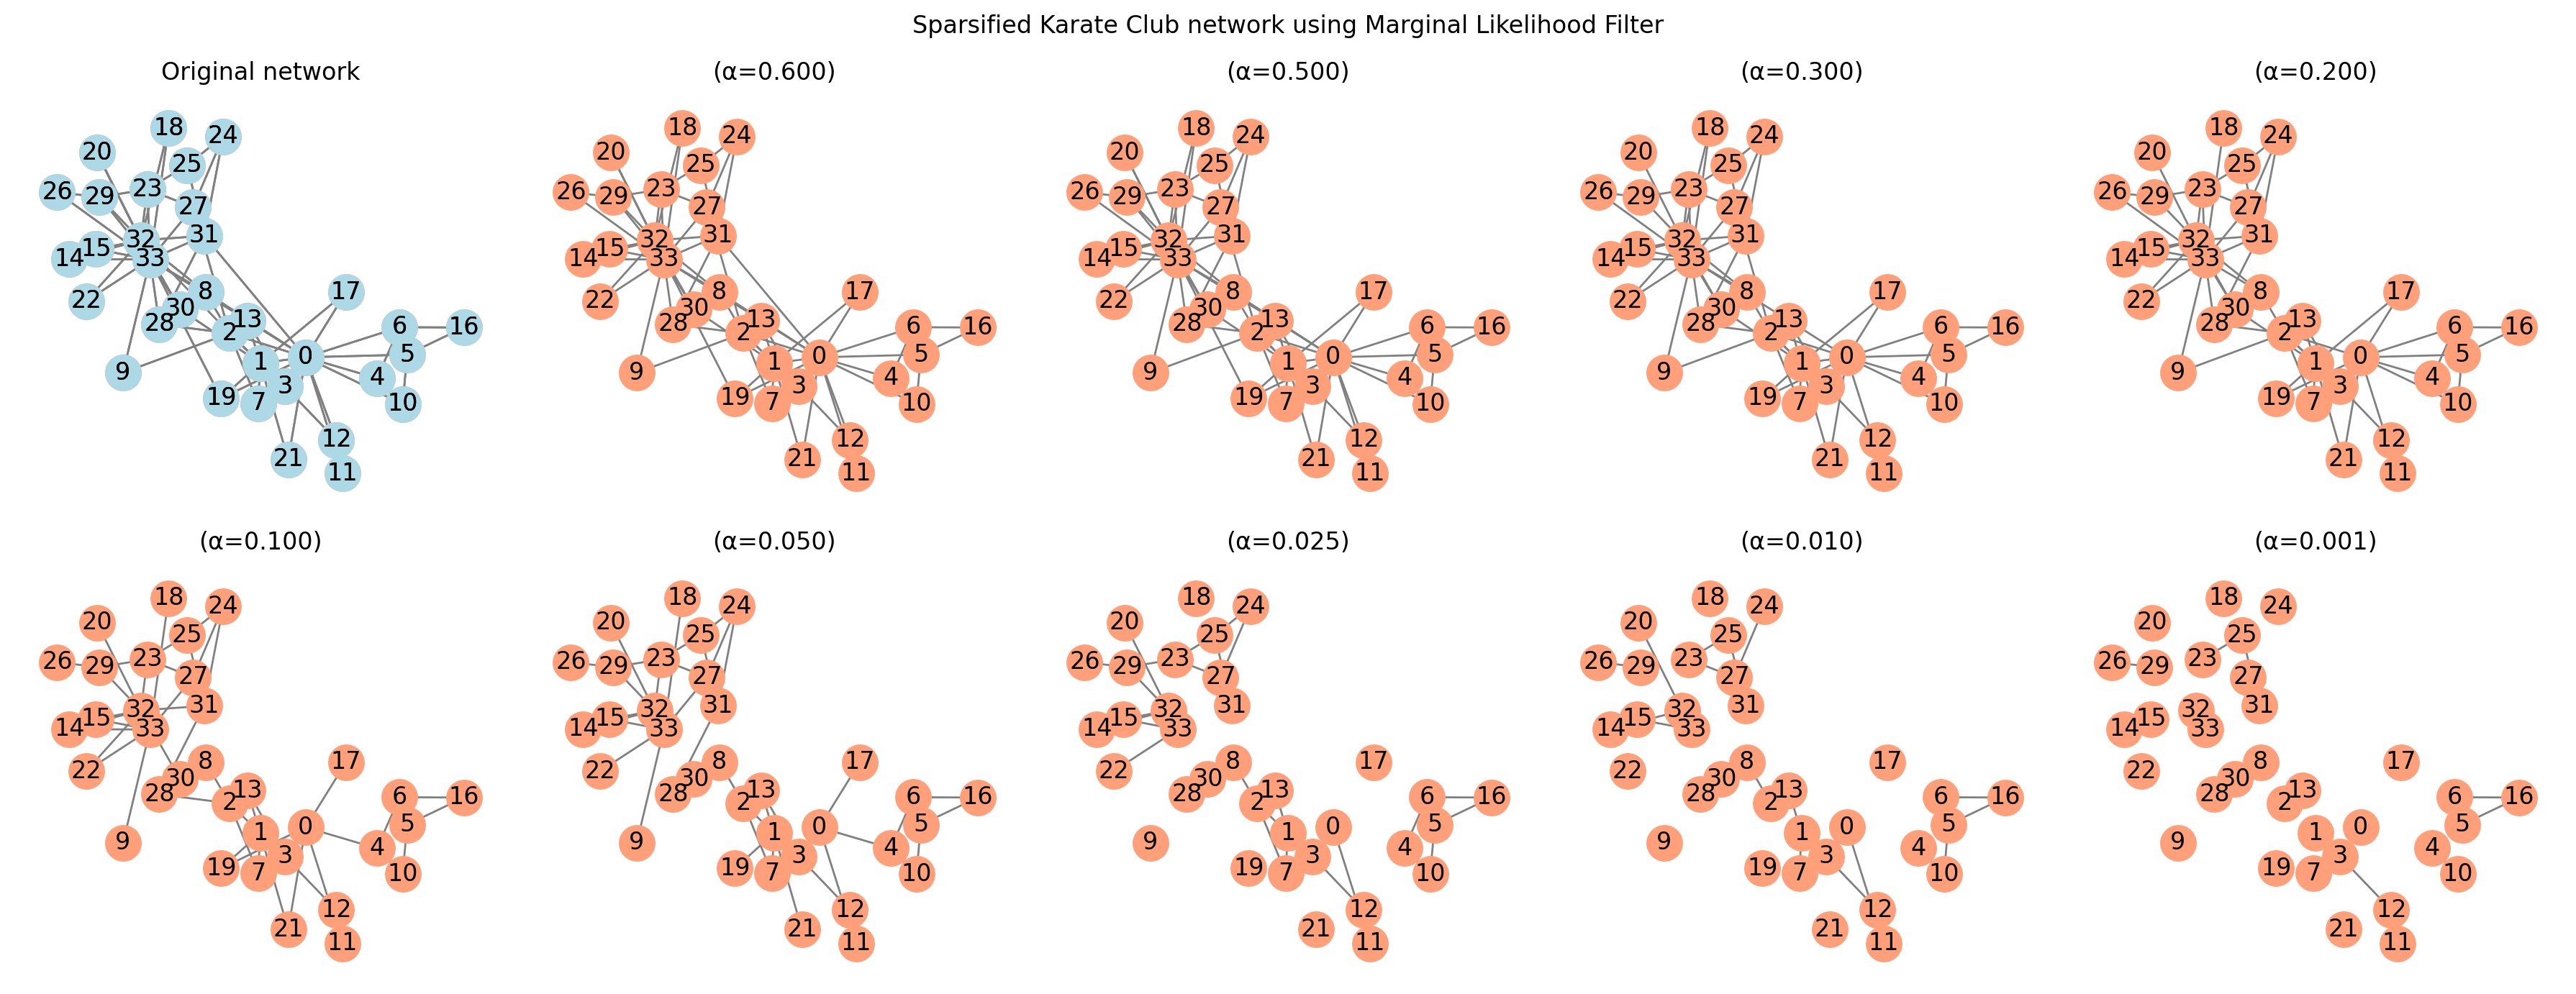

In [24]:
sparsified_graphs = {}
alphas = [0.001, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7]

positions = nx.spring_layout(G, seed=3141592)

fig, axes = plt.subplots(2, 5, figsize=(18, 7), sharex=True, sharey=True, dpi=200) 

for i, alpha in enumerate(alphas[:10]):
    sparsified_graphs[alpha] = marginal_likelihood_filter(G, alpha)

    nx.draw(
        sparsified_graphs[alpha], 
        pos=positions, 
        ax=axes.flat[-(i + 1)], 
        with_labels=True, 
        node_color="lightsalmon", 
        edge_color="gray"
    )
    axes.flat[-(i + 1)].set_title(f"(α={alpha:.3f})")

# Original network
nx.draw(
    G, 
    pos=positions, 
    ax=axes.flat[0], 
    with_labels=True, 
    node_color="lightblue", 
    edge_color="gray"
)
axes.flat[0].set_title("Original network")
plt.suptitle("Sparsified Karate Club network using Marginal Likelihood Filter")
plt.tight_layout()

plt.show()

## Evaluation techniques and applications

Evaluating the performance of backbone extraction methods is essential to ensure their reliability and appropriateness for specific tasks. Below, we will cover t a set of criteria and metrics that can be used to assess the performance of these methods. 

### US domestic flights traffic data 2021-2022

In this section, we will use the domestic nonstop segment of the U.S. airport transportation system for the interval 2021-2022, which can be downloaded from [here](https://www.bts.gov/browse-statistical-products-and-data/bts-publications/data-bank-28ds-t-100-domestic-segment-data).

In [25]:
df = pd.read_table("data/db28seg.dd.wac.2021.2022.asc", sep="|", low_memory=False)
df

year  month origin  origin_city_market_id  origin_wac  \
0       2021      5    01A                  30001           1   
1       2021      8    01A                  30001           1   
2       2022      8    01A                  30001           1   
3       2021      8    01A                  30001           1   
4       2021      9    01A                  30001           1   
...      ...    ...    ...                    ...         ...   
787386  2021      4    ZXU                  36353          15   
787387  2021     12    ZXU                  36353          15   
787388  2022     12    ZXU                  36353          15   
787389  2021      9    ZXU                  36353          15   
787390  2021      4    ZZV                  36361          44   

           origin_city_name dest  dest_city_market_id  dest_wac  \
0          Afognak Lake, AK  A43                30056         1   
1          Afognak Lake, AK  A43                30056         1   
2          Afognak Lake, AK  A43                30056         1   
3          Afognak Lake, AK  A43                30056         1   
4          Afognak Lake, AK  A43                30056         1   
...                     ...  ...                  ...       ...   
787386  North Kingstown, RI  TEB                35167        21   
787387  North Kingstown, RI  TEB                35167        21   
787388  North Kingstown, RI  TEB                35167        21   
787389  North Kingstown, RI  TEB                35167        21   
787390       Zanesville, OH  SAT                33214        74   

           dest_city_name  ... departures_scheduled payload  seats  \
0       Kodiak Island, AK  ...                    0    1200      6   
1       Kodiak Island, AK  ...                    0     750      5   
2       Kodiak Island, AK  ...                    0    2400     12   
3       Kodiak Island, AK  ...                    0    2400     12   
4       Kodiak Island, AK  ...                    0    6000     30   
...                   ...  ...                  ...     ...    ...   
787386      Teterboro, NJ  ...                    0    3450      8   
787387      Teterboro, NJ  ...                    0    3450      8   
787388      Teterboro, NJ  ...                    0    3450      8   
787389      Teterboro, NJ  ...                    0    3450      8   
787390    San Antonio, TX  ...                    0    2500      8   

        passengers freight  mail  ramp_to_ramp  air_time  Wac  Unnamed: 28  
0                1       0     0            20        18    1          NaN  
1                1       0     0            30        28    1          NaN  
2                7       0     0            47        43    1          NaN  
3                2       0     0            43        39    1          NaN  
4                0       0     0           105        95    1          NaN  
...            ...     ...   ...           ...       ...  ...          ...  
787386           1       0     0            72        54   10          NaN  
787387           1       0     0            54        36   10          NaN  
787388           1       0     0            54        42   10          NaN  
787389           1       0     0            54        42   10          NaN  
787390           3       0     0           202       194   54          NaN  

[787391 rows x 29 columns]

In [26]:
print("Number of unique origin airports", len(df["origin"].unique()))
print("Number of unique destination airports", len(df["dest"].unique()))
print()
print("Columns:", [column for column in df.columns])

Number of unique origin airports 1547
Number of unique destination airports 1544

Columns: ['year', 'month', 'origin', 'origin_city_market_id', 'origin_wac', 'origin_city_name', 'dest', 'dest_city_market_id', 'dest_wac', 'dest_city_name', 'Carrier', 'Carrier_Entity', 'carrier_group', 'distance', 'Svc_Class', 'Aircraft_Group', 'Aircraft_type', 'Aircraft_Config', 'departures_performed', 'departures_scheduled', 'payload', 'seats', 'passengers', 'freight', 'mail', 'ramp_to_ramp', 'air_time', 'Wac', 'Unnamed: 28']


In [27]:
df["route"] = df.apply(lambda row: tuple(sorted([row["origin"], row["dest"]])), axis=1)
edges = df.groupby("route")["passengers"].sum().reset_index()
edges[["airport_1", "airport_2"]] = pd.DataFrame(edges["route"].tolist(), index=edges.index)
edges = edges.drop(columns=["route"])
edges = edges.loc[edges["passengers"] > 0]
edges = edges.loc[edges["airport_1"] != edges["airport_2"]]
edges.sort_values(by="passengers", ascending=False)

passengers airport_1 airport_2
20617     4823868       JFK       LAX
3523      4774008       ATL       MCO
3458      4467829       ATL       FLL
21518     4326505       LAS       LAX
12428     4181994       DEN       PHX
...           ...       ...       ...
7273            1       BOS       MQY
20918           1       KCQ       ORI
6399            1       BKG       BTL
1714            1       AGN       EXI
26220           1       PAE       SUN

[20607 rows x 3 columns]

Now, in order to produce some nice visualizations, nothing better than use the real coordinates of each airport. However, this is contained on a separate dataset, can also be downloaded [here](https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FLL&QO_fu146_anzr=) [7].

In [28]:
unique_airports = pd.concat([edges["airport_1"], edges["airport_2"]]).unique()
print("Number of unique airports", len(unique_airports))
airport_coords = pd.read_csv("data/airport_coords.csv")
airport_coords = airport_coords[airport_coords["AIRPORT"].isin(unique_airports)].drop_duplicates(subset="AIRPORT", keep="first")
airport_coords

Number of unique airports 1501


AIRPORT_SEQ_ID  AIRPORT_ID AIRPORT     DISPLAY_AIRPORT_NAME  \
0             1000101       10001     01A     Afognak Lake Airport   
3             1000501       10005     05A     Little Squaw Airport   
4             1000601       10006     06A             Kizhuyak Bay   
7             1000901       10009     09A          Augustin Island   
8             1001001       10010     1B1          Columbia County   
...               ...         ...     ...                      ...   
19991         1697401       16974     MD3           Harford County   
19996         1697601       16976     MLJ  Baldwin County Regional   
20000         1697901       16979     MS6   Columbia Marion County   
20004         1698201       16982     2AK                Deer Park   
20007         1698501       16985     A9K      Era Denali Heliport   

      DISPLAY_AIRPORT_CITY_NAME_FULL  AIRPORT_WAC AIRPORT_COUNTRY_NAME  \
0                   Afognak Lake, AK            1        United States   
3                   Little Squaw, AK            1        United States   
4                       Kizhuyak, AK            1        United States   
7                          Homer, AK            1        United States   
8                         Hudson, NY           22        United States   
...                              ...          ...                  ...   
19991                Churchville, MD           35        United States   
19996              Milledgeville, GA           34        United States   
20000                   Columbia, MS           53        United States   
20004                   Deerpark, AK            1        United States   
20007                      Healy, AK            1        United States   

      AIRPORT_COUNTRY_CODE_ISO AIRPORT_STATE_NAME AIRPORT_STATE_CODE  ...  \
0                           US             Alaska                 AK  ...   
3                           US             Alaska                 AK  ...   
4                           US             Alaska                 AK  ...   
7                           US             Alaska                 AK  ...   
8                           US           New York                 NY  ...   
...                        ...                ...                ...  ...   
19991                       US           Maryland                 MD  ...   
19996                       US            Georgia                 GA  ...   
20000                       US        Mississippi                 MS  ...   
20004                       US             Alaska                 AK  ...   
20007                       US             Alaska                 AK  ...   

        LATITUDE  LON_DEGREES LON_HEMISPHERE  LON_MINUTES  LON_SECONDS  \
0      58.109444        152.0              W         54.0         24.0   
3      67.570000        148.0              W         11.0          2.0   
4      57.745278        152.0              W         52.0         58.0   
7      59.362778        153.0              W         25.0         50.0   
8      42.288889         73.0              W         42.0         37.0   
...          ...          ...            ...          ...          ...   
19991  39.566944         76.0              W         12.0          9.0   
19996  33.154167         83.0              W         14.0         29.0   
20000  31.297778         89.0              W         48.0         41.0   
20004  56.519722        134.0              W         40.0         46.0   
20007  63.738333        148.0              W         52.0         54.0   

        LONGITUDE     AIRPORT_START_DATE      AIRPORT_THRU_DATE  \
0     -152.906667   7/1/2007 12:00:00 AM                    NaN   
3     -148.183889   8/1/2007 12:00:00 AM                    NaN   
4     -152.882778  10/1/2007 12:00:00 AM                    NaN   
7     -153.430556   6/1/2008 12:00:00 AM                    NaN   
8      -73.710278   4/1/2009 12:00:00 AM  6/30/2011 12:00:00 AM   
...           ...                    ...                    .

In [29]:
airport_network = nx.Graph()
for _, row in edges.iterrows():
    airport_network.add_edge(row['airport_1'], row['airport_2'], weight=row['passengers'])
airport_network.remove_node("DQG") # No coordinates for this airport

print("Number of nodes", len(airport_network))
print("Number of edges", len(airport_network.edges))

Number of nodes 1500
Number of edges 20598


In [30]:
pos  = airport_coords.set_index('AIRPORT')[['LONGITUDE', 'LATITUDE']].apply(tuple, axis=1).to_dict()

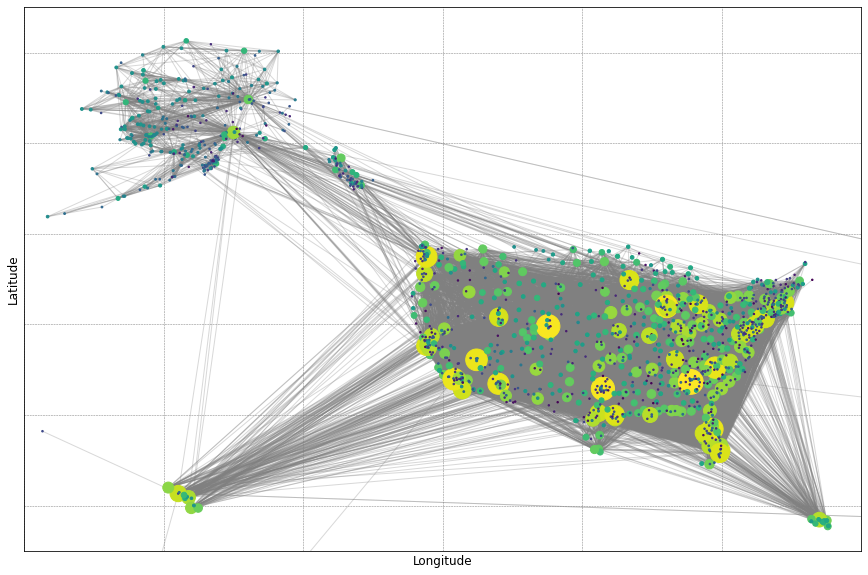

In [31]:
plt.figure(figsize=(15, 10))

plt.xlim(-180, -60) 
plt.ylim(15, 75) 

node_strength = {node: sum(weight for _, _, weight in airport_network.edges(node, data="weight")) for node in airport_network.nodes}
node_sizes = [2 + 0.05 * np.sqrt(node_strength[node]) for node in airport_network.nodes]
node_colors = [np.log10(node_strength[node]) for node in airport_network.nodes]

edge_weights = [np.log10(airport_network[u][v]["weight"]) for u, v in airport_network.edges]

nx.draw_networkx_nodes(airport_network, 
        pos=pos,
        node_color=node_colors,
        node_size=node_sizes,
        cmap=plt.cm.viridis
       )

nx.draw_networkx_edges(airport_network,
        pos=pos,
        alpha=0.3,
        edge_color="gray"
        )

plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)

plt.show()

As we can see, the visualization is not very informative. We can observer some hubs, but it is not possible to observer any useful details. Now, let's try with a sparsified version.

In [32]:
# fig, axes = plt.subplots(1, 3, figsize=(18,6), sharex=True, sharey=True)

# plt.xlim(-180, -60) 
# plt.ylim(15, 75)

# func_names = ["Disparity Filter", "Marginal Likelihood Filter",  "Maximum Spanning Tree"]
# backbone_functions = [extract_backbone, marginal_likelihood_filter, nx.maximum_spanning_tree]
# parameters = [0.01, 0.00001]
# sparsified_networks = []

# for i, func in enumerate(backbone_functions):
#     if i < 3:
#         airport_network_sparsified = func(airport_network, parameters[i])
#     else:
#         airport_network_sparsified = func(airport_network)
#     sparsified_networks.append(airport_network_sparsified)
#     node_strength = {node: sum(weight for _, _, weight in airport_network_sparsified.edges(node, data="weight")) for node in airport_network_sparsified.nodes}
#     node_sizes = [2 + 0.02 * np.sqrt(node_strength[node]) for node in airport_network_sparsified.nodes]
#     node_colors = [np.log10(node_strength[node]) for node in airport_network_sparsified.nodes]
#     axes.flat[i].set_xlim(-180, -60)
#     axes.flat[i].set_ylim(15, 75)
#     nx.draw_networkx_nodes(airport_network_sparsified, 
#             pos=pos,
#             ax=axes.flat[i],
#             node_color=node_colors,
#             node_size=node_sizes,
#             cmap=plt.cm.viridis
#            )
    
#     nx.draw_networkx_edges(airport_network_sparsified,
#             pos=pos,
#             ax=axes.flat[i],
#             alpha=0.3,
#             edge_color="gray"
#             )
#     axes.flat[i].grid(color='gray', linestyle='--', linewidth=0.5)
#     axes.flat[i].set_xlabel("Longitude", fontsize=12)
#     axes.flat[i].set_ylabel("Latitude", fontsize=12)
#     axes.flat[i].set_title(func_names[i])
# plt.tight_layout()
# plt.show()


## Conclusion

Large and complex networks often present significant challenges. The sheer number of nodes and edges can make them difficult to analyze, computationally expensive to process, and hard to interpret visually. This is where network sparsification becomes a valuable tool. By simplifying networks and keeping only the most important connections, we can make our work much more efficient and focused, while still preserving the key information we need.

The main lesson here is that each method serves a specific purpose, and choosing the right one depends on your goal. Do you want a clearer visualization? Do you need to preserve connectivity? Or are you looking to make computations faster? Sparsification offers tools to meet these needs, and **experimenting is an essential item in the network scientist toolkit** in order to find the best approach.

### Further reading

We recommend consulting documentation for the [`netbone`](https://gitlab.liris.cnrs.fr/coregraphie/netbone) Python library, which implements all the techniques covered in this notebook, as well a many more state-of-the-art backbone extraction methods. Also, it offers a complete evaluation framework.

For other applications, read:

Mercier, A., Scarpino, S., & Moore, C. (2022). Effective resistance against pandemics: Mobility network sparsification for high-fidelity epidemic simulations. PLoS Computational Biology, 18(11), e1010650. https://doi.org/10.1371/journal.pcbi.1010650

Neal, Z. (2014). The backbone of bipartite projections: Inferring relationships from co-authorship, co-sponsorship, co-attendance and other co-behaviors. Social Networks, 39, 84–97. https://doi.org/10.1016/j.socnet.2014.06.001

__________
## Next time...
Network Sampling `class_22_sampling.ipynb`
_______

## References and further resources:

1. Class Webpages
    - Jupyter Book: https://network-science-data-and-models.github.io/phys7332_fa25/README.html
    - Github: https://github.com/network-science-data-and-models/phys7332_fa25/
    - Syllabus and course details: https://brennanklein.com/phys7332-fall25
2. Alvarez-Hamelin, J. I., Dall'Asta, L., Barrat, A., & Vespignani, A. (2005). k-core decomposition: A tool for the visualization of large scale networks. arXiv preprint cs/0504107.
3. Bonanno, G., Caldarelli, G., Lillo, F., & Mantegna, R. N. (2003). Topology of correlation-based minimal spanning trees in real and model markets. Physical Review E, 68(4), 046130.
4. Daqing, L., Kosmidis, K., Bunde, A., & Havlin, S. (2011). Dimension of spatially embedded networks. Nature Physics, 7(6), 481-484.
5. Gfeller, D., & De Los Rios, P. (2007). Spectral coarse graining of complex networks. Physical review letters, 99(3), 038701.
6. Graham, R. L., & Hell, P. (1985). On the history of the minimum spanning tree problem. Annals of the History of Computing, 7(1), 43-57.
7. Radicchi, F., Ramasco, J. J., & Fortunato, S. (2011). Information filtering in complex weighted networks. Physical Review E, 83(4), 046101.
8. Seidman, S. B. (1983). Network structure and minimum degree. Social networks, 5(3), 269-287.
9. Serrano, M. Á., Boguná, M., & Vespignani, A. (2009). Extracting the multiscale backbone of complex weighted networks. Proceedings of the national academy of sciences, 106(16), 6483-6488.
10. Serrano, M. Á., Boguñá, M., & Sagués, F. (2012). Uncovering the hidden geometry behind metabolic networks. Molecular BioSystems, 8(3), 843-850.
11. Tumminello, M., Aste, T., Di Matteo, T., & Mantegna, R. N. (2005). A tool for filtering information in complex systems. Proceedings of the National Academy of Sciences of the United States of America, 102(30), 10421-10426.
12. D. A. Spielman and N. Srivastava, “Graph sparsification by effective resistances,” *SIAM Journal on Computing* 40(6):1913-1926, 2011.

- A. A. Benczúr and D. R. Karger, “Randomized approximation schemes for cuts and flows in capacitated graphs,” *SIAM Journal on Computing* 44(2):290-319, 2015.

- M. Hamann, G. Lindner, H. Meyerhenke, C. L. Staudt, and D. Wagner, “Structure-preserving sparsification methods for social networks,” *Social Network Analysis and Mining* 6:23, 2016.

- M. Á. Serrano, M. Boguná, and A. Vespignani, “Extracting the multiscale backbone of complex weighted networks,” *Proceedings of the National Academy of Sciences* 106(16):6483-6488, 2009.

- N. Dianati, “Unwinding the hairball graph: pruning algorithms for weighted complex networks,” *Physical Review E* 93:012304, 2016.